In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp

# A. Reply Network

In [2]:
bsky_df = pd.read_csv("../data/bsky_reply_stats.csv")
ts_df = pd.read_csv("../data/ts_reply_stats.csv")

ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [3]:
bsky_df.topic_label.value_counts()

topic_label
Trump’s Legal Convictions and Felony Charges                       20600
Biden vs. Trump Presidential Debates                               18041
Israel-Hamas Conflict and Biden’s Ceasefire Proposal                9223
Hunter Biden’s Legal Troubles (e.g., Gun Charges)                   6946
U.S. Policy on Ukraine and Russia                                   6463
Trump’s Tax Promises and Election Campaign                          5539
Biden’s Immigration Policies and Executive Orders                   4360
Legal Proceedings in Georgia’s 2020 Election Case Against Trump     3193
Trump’s Rallies and Live Events Coverage                            2428
Celebrations of Trump (e.g., Birthdays and Tributes)                1525
Pro-Trump and MAGA Advocacy                                         1070
Criticism of Trump and Support for Democratic Policies                 4
Name: count, dtype: int64

In [4]:
import json
with open("../data/ts_threads.json", "r") as f:
    ts_raw = json.load(f)

trump_posts = []
for post in ts_raw:
    if post["account"]["username"] == "realDonaldTrump":
        trump_posts.append(post['_id'])
len(trump_posts)

142

In [5]:
#get trump tweets
trump_posts = [int(x) for x in trump_posts]
ts_df_without_trump = ts_df[~ts_df['index'].isin(trump_posts)]


In [6]:
ts_df_without_trump

index  max_depth   size  breadth  structural_virality  \
0      112621599737106709        2.0   23.0     19.0             1.120000   
3      112605503664527349        1.0   13.0     12.0             1.000000   
4      112631948496888276        4.0   40.0     31.0             1.396226   
6      112605675198604099        2.0   71.0     58.0             1.146341   
7      112617674695396546        7.0  286.0    252.0             1.270030   
...                   ...        ...    ...      ...                  ...   
43813  112662952812123107        0.0    1.0      1.0             0.000000   
43814  112686118077882132        2.0    3.0      1.0             1.333333   
43815  112581278824456901        0.0    1.0      1.0             0.000000   
43816  112532468883570221        0.0    1.0      1.0             0.000000   
43817  112571790544026164        1.0    2.0      1.0             1.000000   

       reach                                               post  \
0       23.0  Trump Trump Trump Trump Trump Trump Trump Trum...   
3       13.0                                             Trump!   
4       40.0             Trump, Donald Trump Shaken not stirred   
6       71.0                              BETTER OFF WITH TRUMP   
7      286.0  "VOTE FOR TRUMP BECAUSE THERE'S NO TAX ON TIPS...   
...      ...                                                ...   
43813    1.0  Everything Trump touches dies. Including Chris...   
43814    3.0  I know it has been said many times before, but...   
43815    1.0  Anyone who has any complaints about Trump need...   
43816    1.0  MAGA IS ALREADY LEAVING TRUTH SOCIAL. PEOPLE A...   
43817    2.0  @ Youneedtherapy Referring to Gen. John Kelly,...   

                                             topic_label platform  
0                            Pro-Trump and MAGA Advocacy       ts  
3           Trump’s Legal Convictions and Felony Charges       ts  
4           Trump’s Legal Convictions and Felony Charges       ts  
6           Trump’s Legal Convictions and Felony Charges       ts  
7             Trump’s Tax Promises and Election Campaign       ts  
...                                                  ...      ...  
43813               Biden vs. Trump Presidential Debates       ts  
43814  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       ts  
43815               Biden vs. Trump Presidential Debates       ts  
43816                        Pro-Trump and MAGA Advocacy       ts  
43817       Trump’s Legal Convictions and Felony Charges       ts  

[43676 rows x 9 columns]

In [7]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
ts_df = ts_df[columns_to_keep].reset_index(drop=True)
ts_df_without_trump['platform'] = 'ts_without_trump'
df = pd.concat([bsky_df, ts_df,ts_df_without_trump], ignore_index=True)
df = df.dropna(subset=["topic_label"])

metrics = ["max_depth", "size", "breadth", "structural_virality"]


In [8]:
# Merge similar topics
df["topic_label"] = df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [9]:
# Drop specified topic
df = df[df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_3924060/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3924060/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


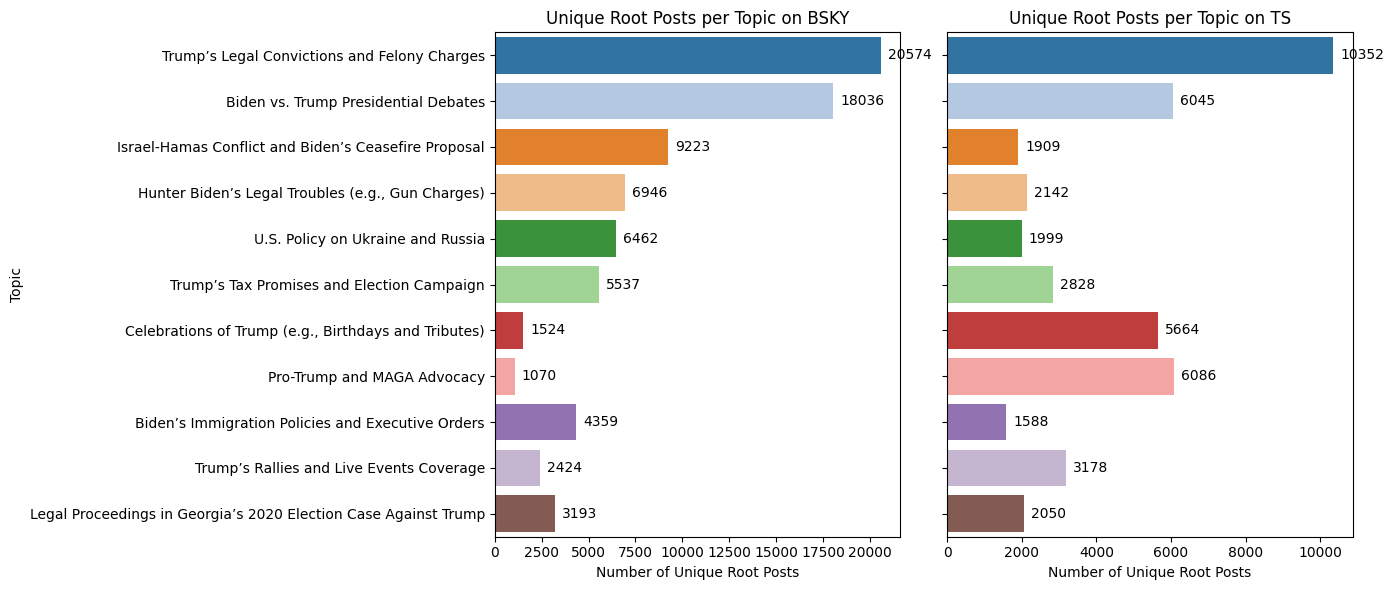

In [10]:
# Ensure consistent order of topics across both platforms
topic_order = (
    df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

### Observation
- The number of root posts under different topics on 2 platforms are different.
- Presidential debates and Trump legal convictions are two topics that have the most root posts on both platforms.
- For the rest of topics, it is clear that Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.


## 2. general cross-platform comparison

In [11]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ts_without_vals = df[df["platform"] == "ts_without_trump"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_without_stat, p_without_value = ks_2samp(bsky_vals, ts_without_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})
    ks_results.append({"Metric": metric, "KS Statistic": ks_without_stat, "P-value": p_without_value})

ks_overall_df = pd.DataFrame(ks_results)


In [12]:
ts_df.sort_values(by='size',ascending=False).head(10)

platform                                        topic_label  max_depth  \
2296        ts                  U.S. Policy on Ukraine and Russia       72.0   
13131       ts         Trump’s Tax Promises and Election Campaign       38.0   
11570       ts               Biden vs. Trump Presidential Debates       35.0   
42677       ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...      175.0   
542         ts  Biden’s Immigration Policies and Executive Orders      128.0   
4338        ts               Biden vs. Trump Presidential Debates      160.0   
8288        ts           Trump’s Rallies and Live Events Coverage       21.0   
5117        ts               Biden vs. Trump Presidential Debates      114.0   
42958       ts         Trump’s Tax Promises and Election Campaign      278.0   
1093        ts                  U.S. Policy on Ukraine and Russia      104.0   

          size  breadth               index  structural_virality  
2296   12594.0    404.0  112621173765349628            19.632883  
13131  11642.0   4605.0  112644111233618072             8.233657  
11570  11531.0   4900.0  112673301719650670             3.236402  
42677  11242.0    213.0  112588259076987596            49.714470  
542     9722.0   3521.0  112632701426261593            32.166800  
4338    8889.0   1630.0  112571273082033339            47.626109  
8288    8492.0   4810.0  112532453963389112             2.347361  
5117    8324.0   1876.0  112558802830902501            32.982066  
42958   8122.0     97.0  112556547330528263            78.818273  
1093    7993.0   3252.0  112593884606525883            26.608677

In [13]:
# Function to compute CCDF
def empirical_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

In [14]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(
    np.linspace(0, 1, len(sorted(df["topic_label"].unique())))
)  # Use tab20 colormap
sorted_topics = sorted(df["topic_label"].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}


def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data["topic_label"] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(
            sorted_vals,
            ccdf_vals,
            label=f"{topic}",
            linewidth=2,
            color=topic_color_map[topic],
        )
    ax.set_xscale("log")  # Apply log scale to x-axis
    ax.set_yscale("log")
    ax.set_xlabel(metric)
    ax.set_ylabel("CCDF (%)")
    ax.set_title(f"CCDF of {metric} by Topic")
    ax.grid()


In [15]:
axes[idx]

<Axes: title={'center': 'Unique Root Posts per Topic on TS'}, xlabel='Number of Unique Root Posts', ylabel='Topic'>

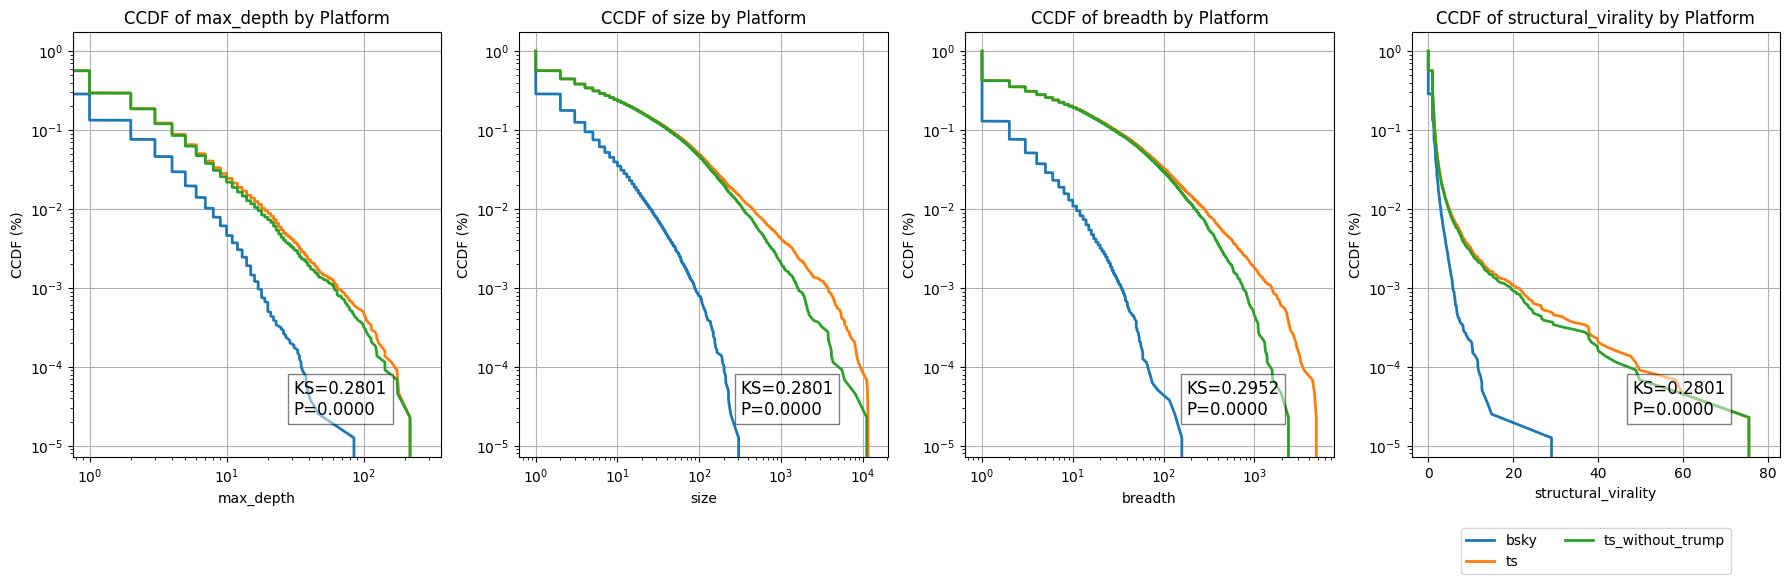

In [16]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts", "ts_without_trump"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

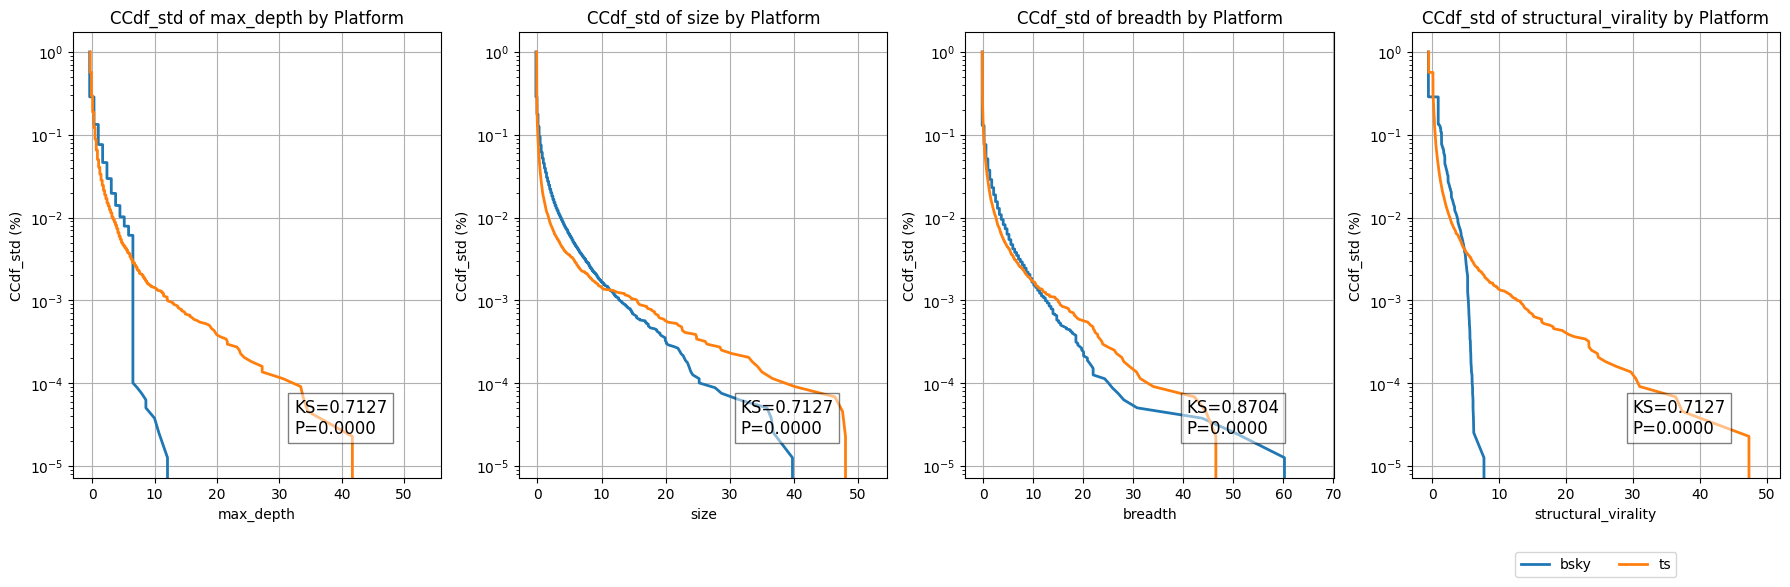

In [28]:
# Standardize the data
df_std = df.copy()
mask_bsky = df_std["platform"] == "bsky"
df_std.loc[mask_bsky, metrics] = (
    df_std.loc[mask_bsky, metrics] - df_std.loc[mask_bsky, metrics].mean()
) / df_std.loc[mask_bsky, metrics].std()

# Standardize the metrics for platform "ts"
mask_ts = df_std["platform"] == "ts"
df_std.loc[mask_ts, metrics] = (
    df_std.loc[mask_ts, metrics] - df_std.loc[mask_ts, metrics].mean()
) / df_std.loc[mask_ts, metrics].std()

# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df_std[df_std["platform"] == "bsky"][metric].dropna()
    ts_vals = df_std[df_std["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df_std = pd.DataFrame(ks_results)
# Plot CCdf_std comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df_std[df_std["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf_std = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf_std, label=f"{platform}", linewidth=2)

    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCdf_std (%)")
    axes[idx].set_title(f"CCdf_std of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df_std.loc[
        ks_overall_df_std["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

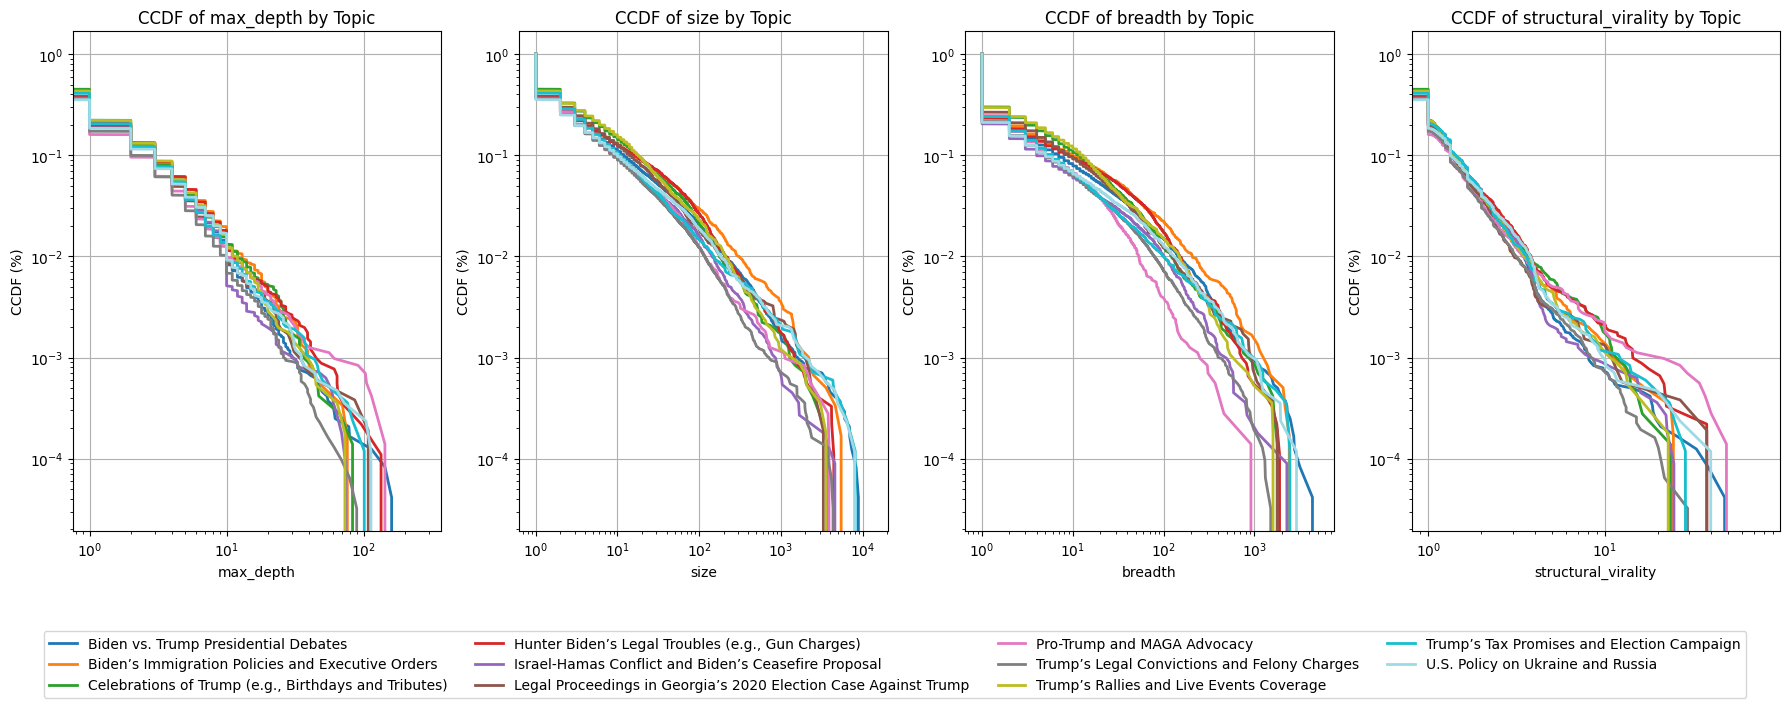

In [29]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

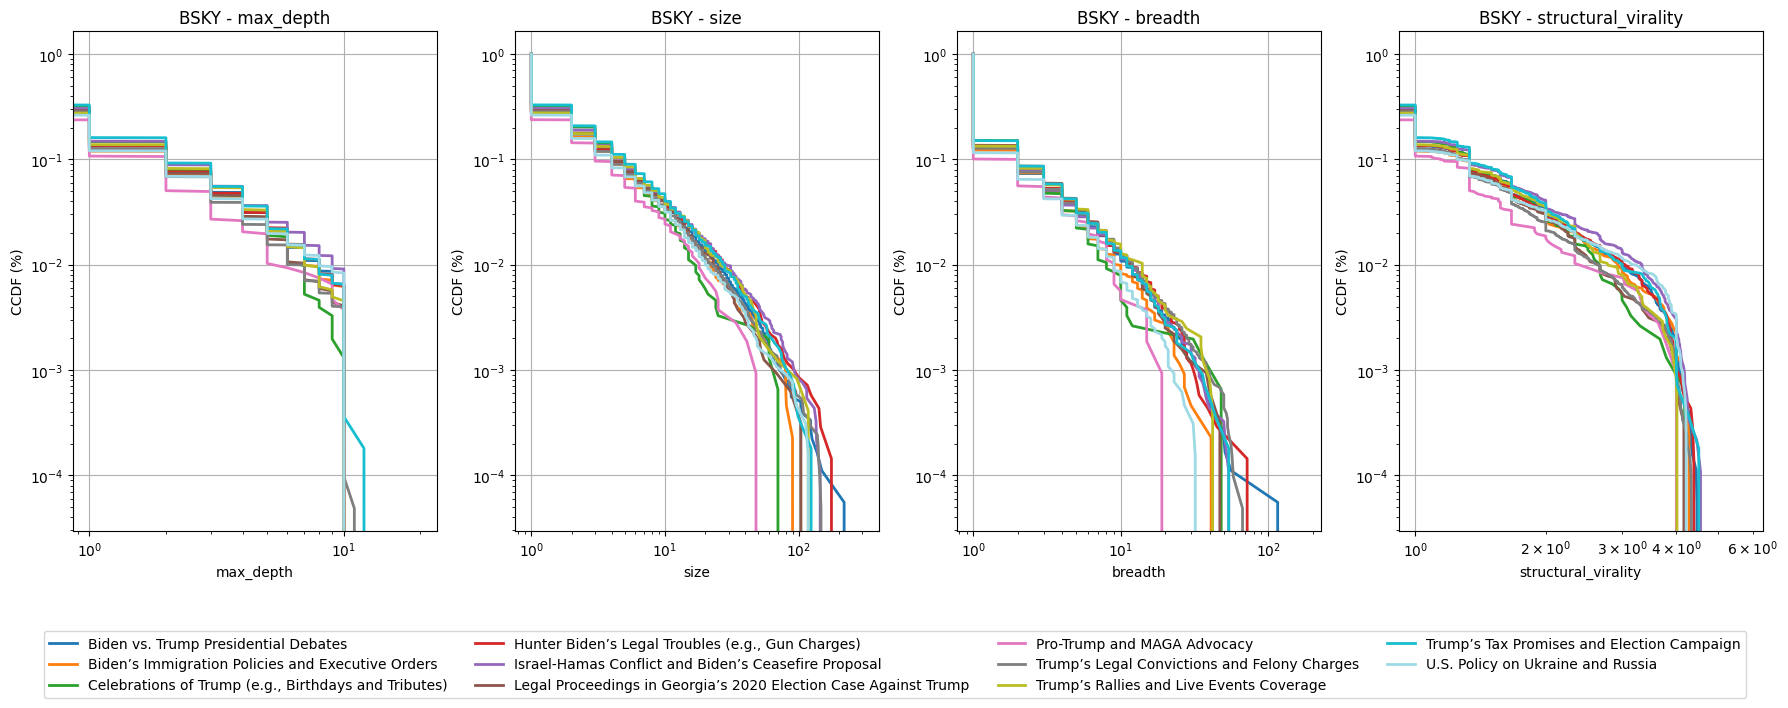

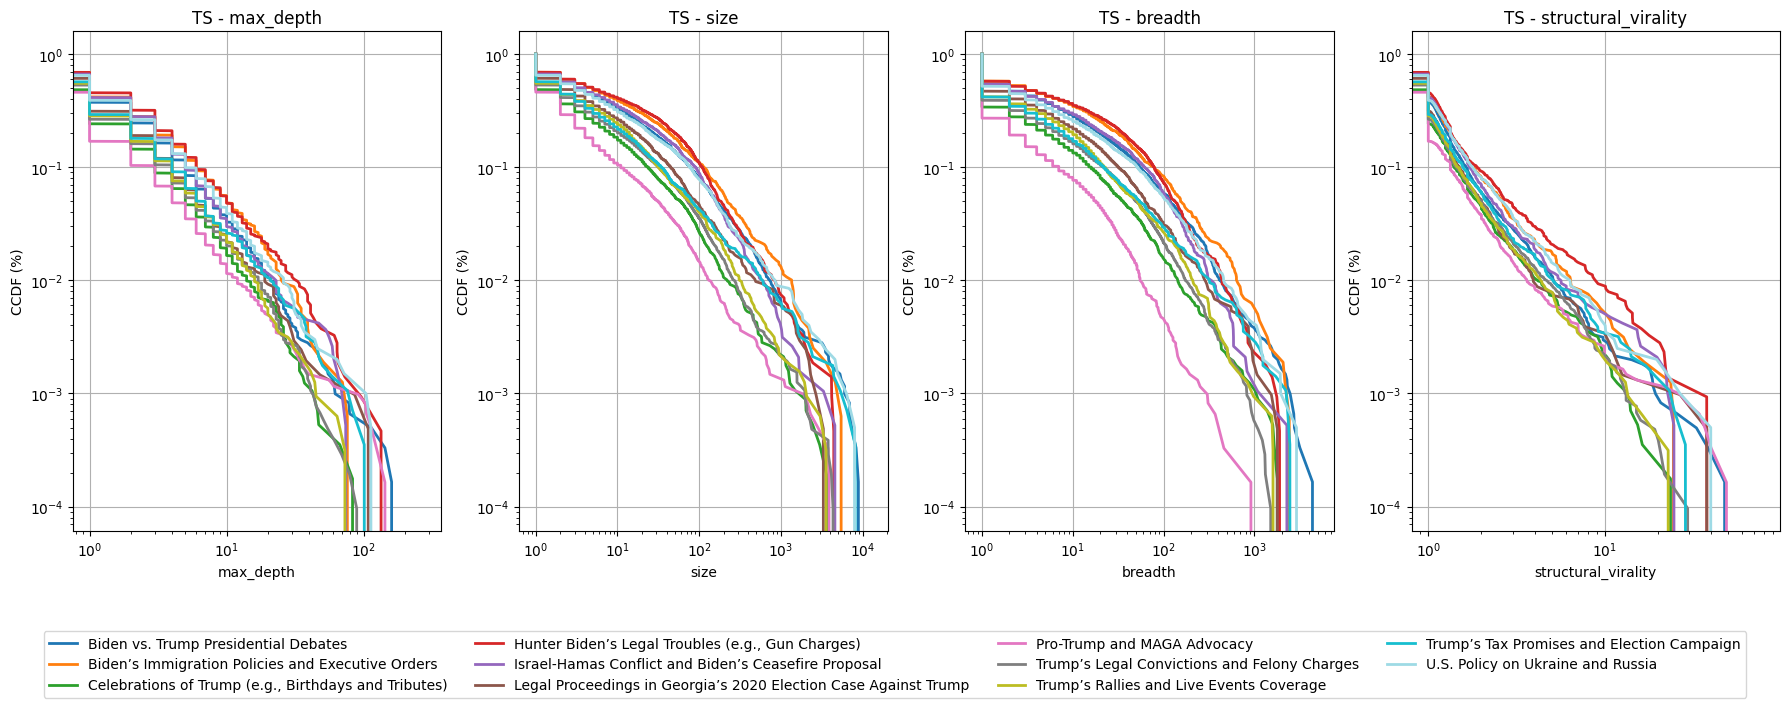

In [58]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = df[df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()


## 5. Quantify the difference

# B. Reposts Network

In [17]:
rp_bsky_df = pd.read_csv("../data/bsky_repost_stats.csv")
rp_ts_df = pd.read_csv("../data/ts_repost_stats.csv")

rp_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [18]:
rp_bsky_df.reset_index(inplace=True)

In [58]:
rp_ts_df_without_trump = rp_ts_df[~rp_ts_df['root_id'].isin(trump_posts)]
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)
rp_ts_df = rp_ts_df[columns_to_keep].reset_index(drop=True)
rp_ts_df_without_trump = rp_ts_df_without_trump[columns_to_keep].reset_index(drop=True)
rp_ts_df_without_trump['platform'] = 'ts_without_trump'
rp_df = pd.concat([rp_bsky_df, rp_ts_df, rp_ts_df_without_trump], ignore_index=True)

rp_df = rp_df.dropna(subset=["topic_label"])


In [59]:
rp_df["topic_label"] = rp_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

rp_df = rp_df[
    rp_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of reposts under different topics on 2 platforms

/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


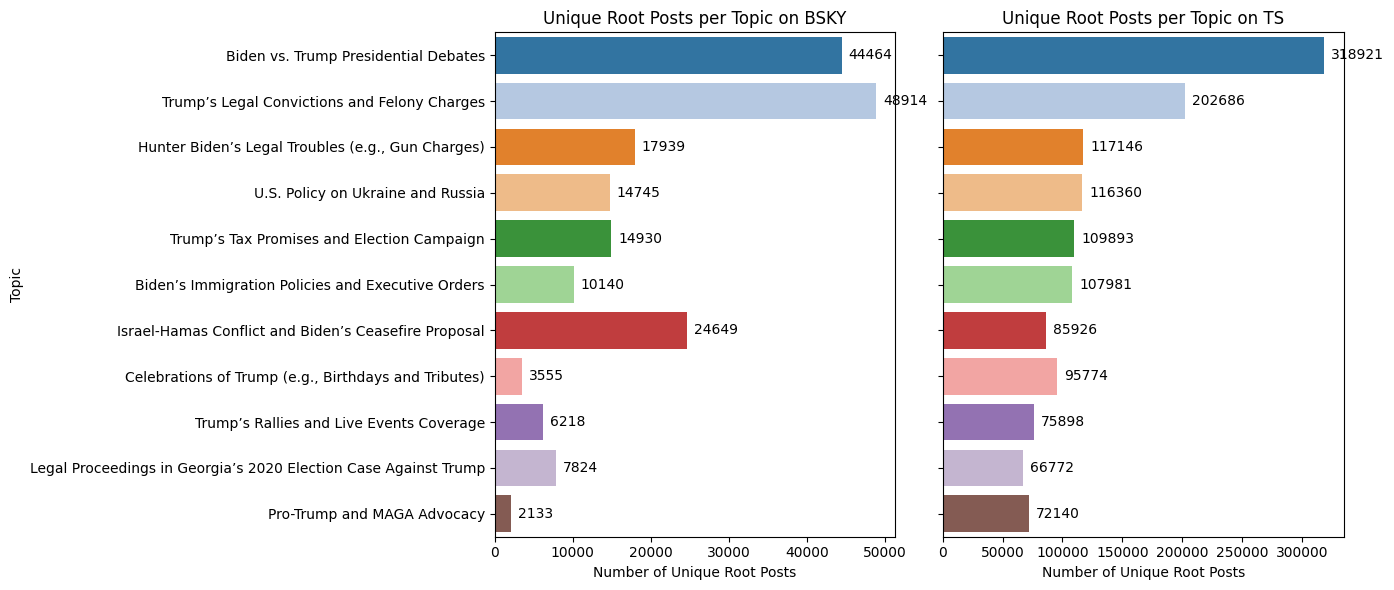

In [35]:
topic_order = (
    rp_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = rp_df[rp_df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()


## 2. General cross-platform comparison

In [60]:
rp_metrics = ["max_depth", "size", "breadth", "structural_virality"]

ks_results = []
for metric in rp_metrics:
    bsky_vals = rp_df[rp_df["platform"] == "bsky"][metric].dropna()
    ts_vals = rp_df[rp_df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


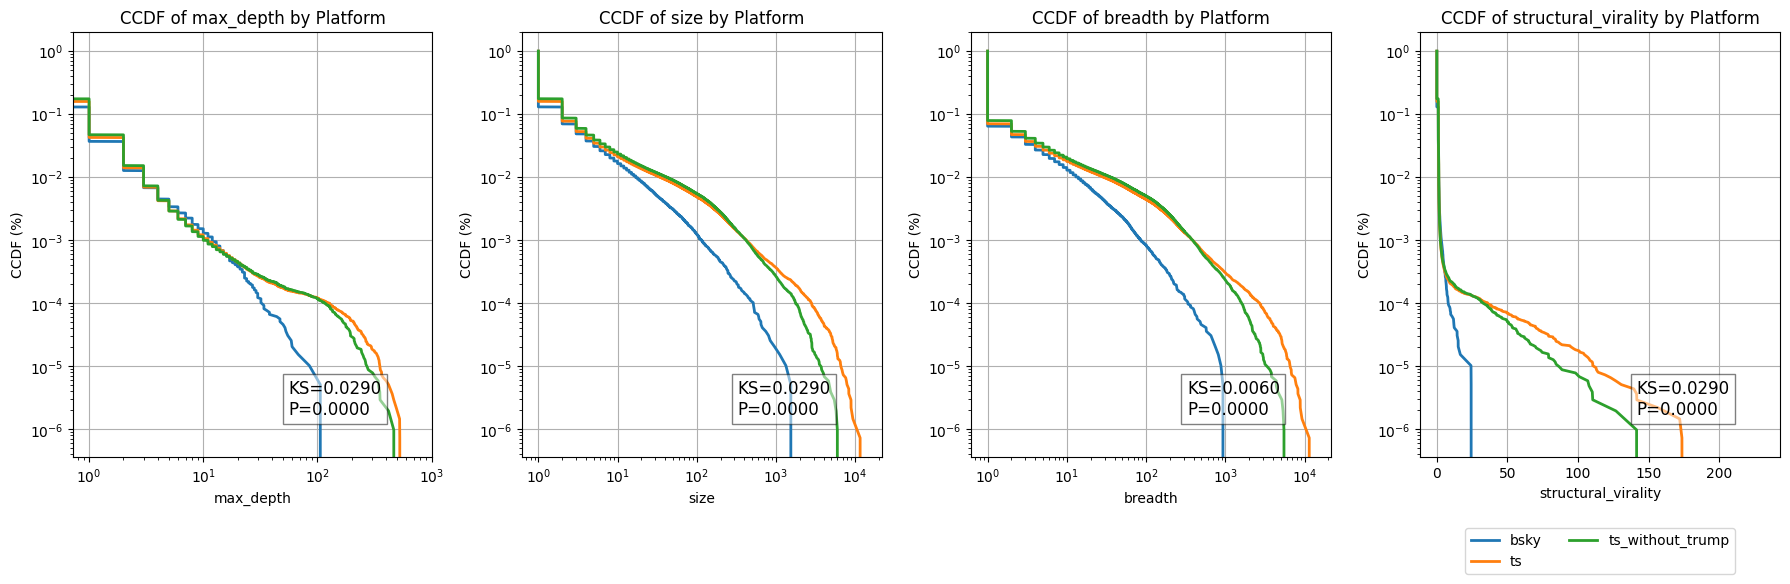

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(rp_metrics):
    for platform in ["bsky", "ts", "ts_without_trump"]:
        values = rp_df[rp_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()


## 3. General cross-topic comparison

In [62]:
plt.figure(rows=2, cols=1)
plt.scatter(rp_bsky_df["max_depth"], rp_bsky_df["size"])
plt.scatter(rp_ts_df["max_depth"], rp_ts_df["size"])
plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'rows'

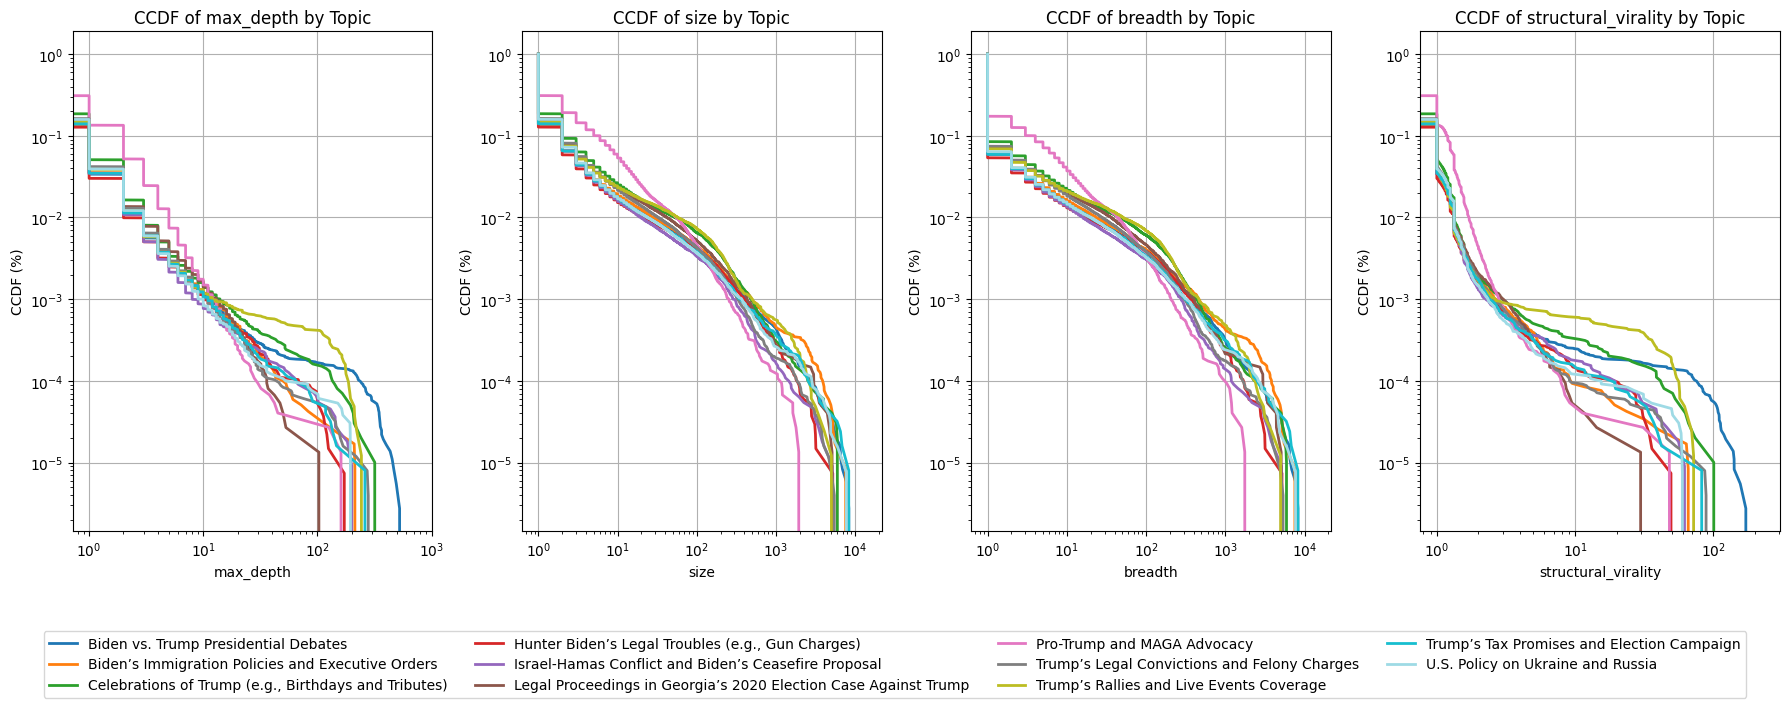

In [40]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(rp_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. Comparison by platform & by topic

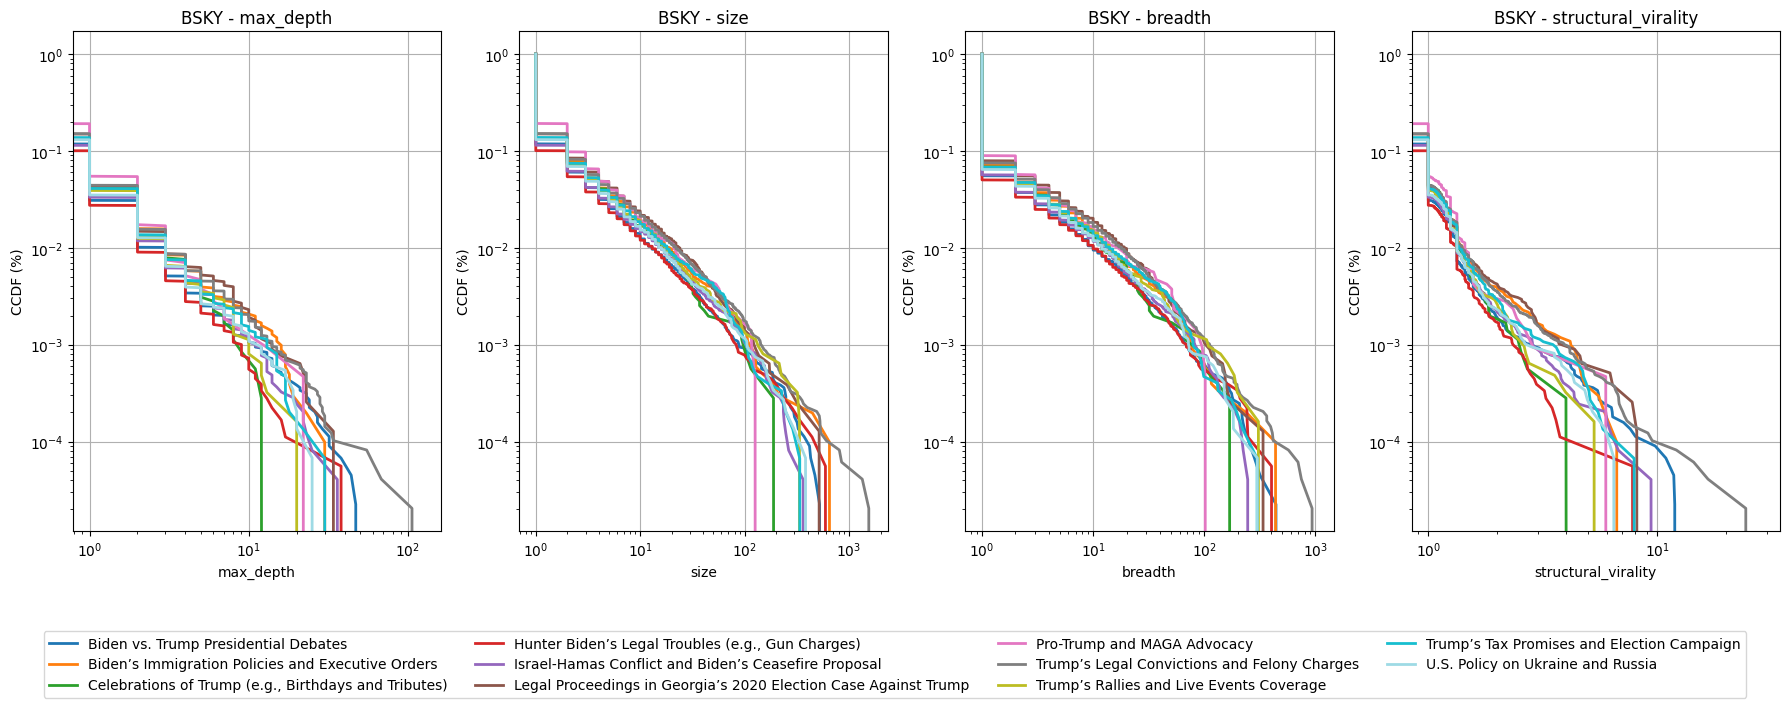

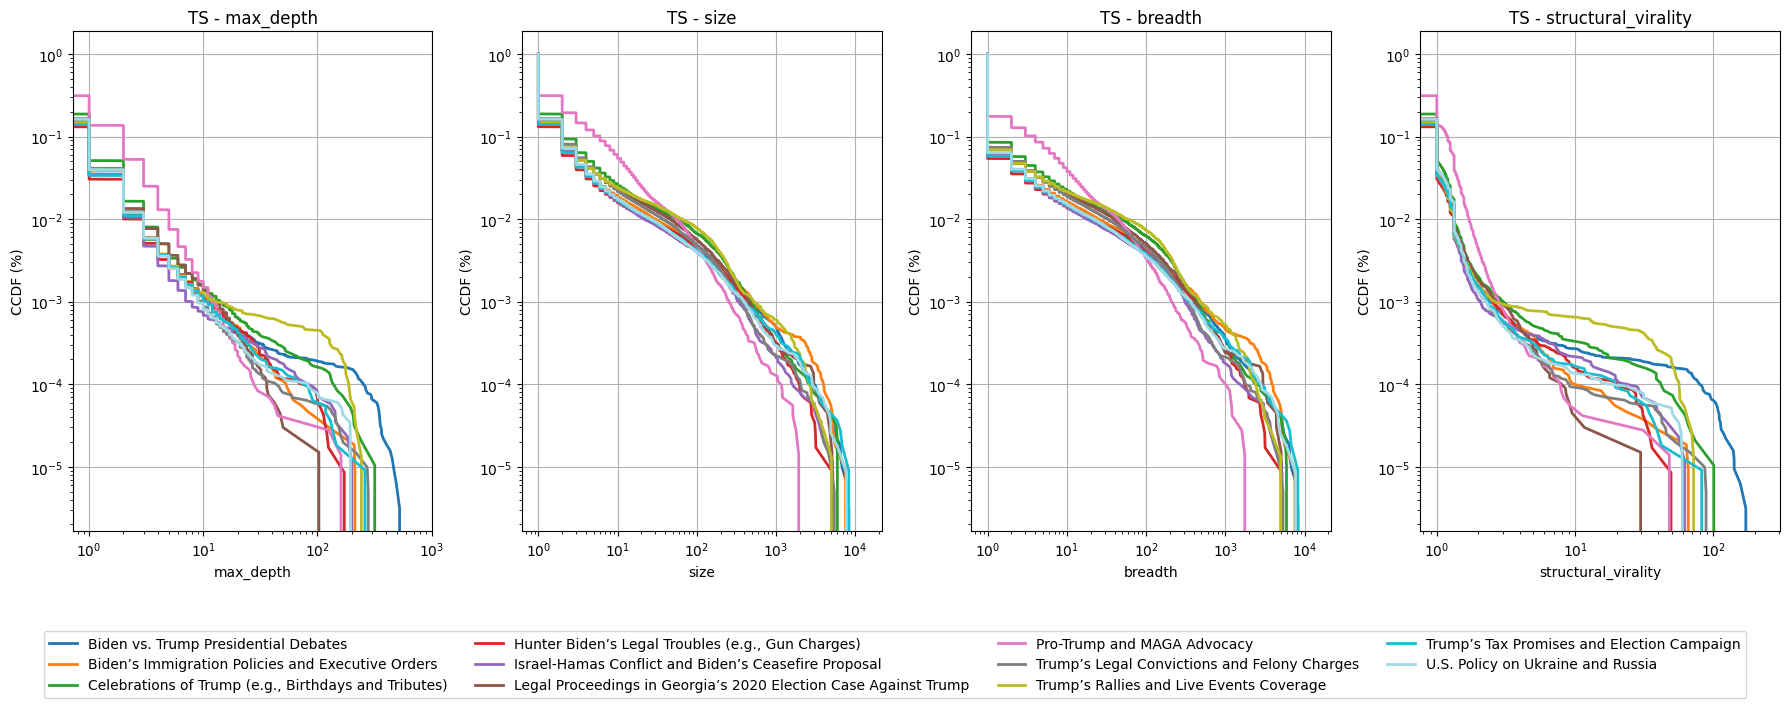

In [57]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = rp_df[rp_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# C. Combined Network

In [44]:
c_bsky_df = pd.read_csv("../data/bsky_combined_stats.csv")
c_ts_df = pd.read_csv("../data/ts_combined_stats.csv")

c_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [45]:
c_bsky_df = c_bsky_df[columns_to_keep].reset_index(drop=True)
c_ts_df = c_ts_df[columns_to_keep].reset_index(drop=True)

c_df = pd.concat([c_bsky_df, c_ts_df], ignore_index=True)
c_df = c_df.dropna(subset=["topic_label"])

In [46]:
# Merge similar topics
c_df["topic_label"] = c_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [47]:
# Drop specified topic
c_df = c_df[
    c_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


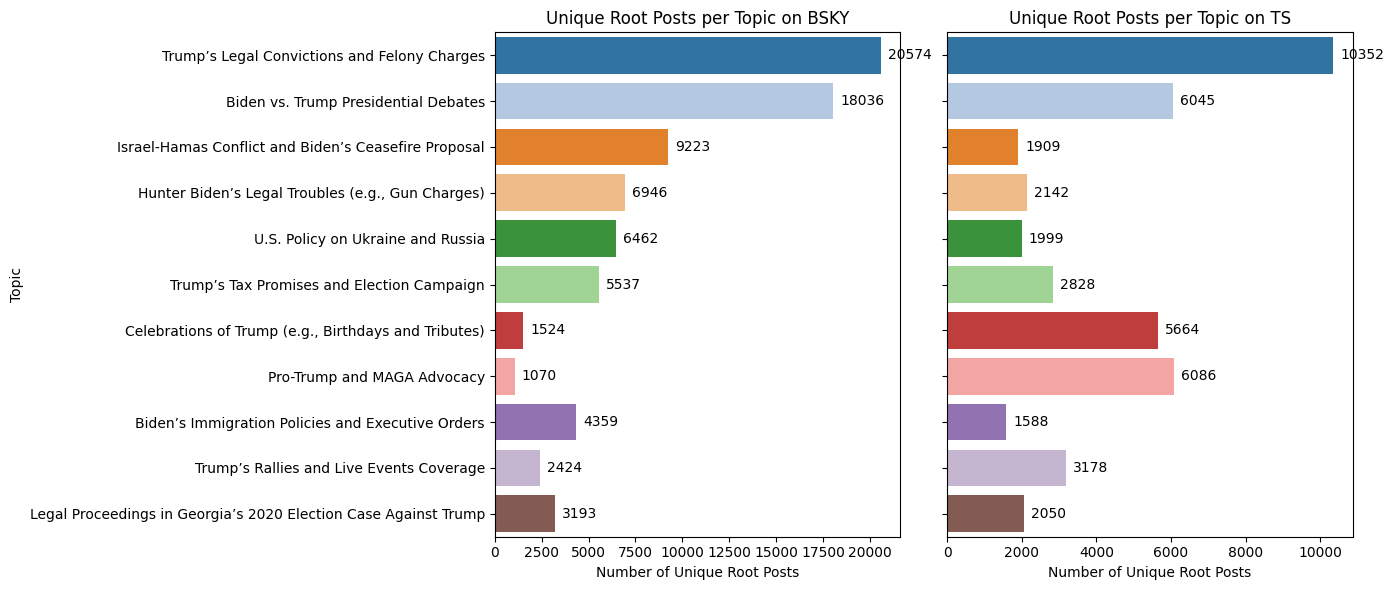

In [48]:
# Ensure consistent order of topics across both platforms
topic_order = (
    c_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

## 2. general cross-platform comparison

In [49]:
# Compute KS statistics for each metric
c_ks_results = []
for metric in metrics:
    c_bsky_vals = c_df[c_df["platform"] == "bsky"][metric].dropna()
    c_ts_vals = c_df[c_df["platform"] == "ts"][metric].dropna()
    c_ks_stat, c_p_value = ks_2samp(c_bsky_vals, c_ts_vals)
    c_ks_results.append(
        {"Metric": metric, "KS Statistic": c_ks_stat, "P-value": c_p_value}
    )

c_ks_overall_df = pd.DataFrame(c_ks_results)

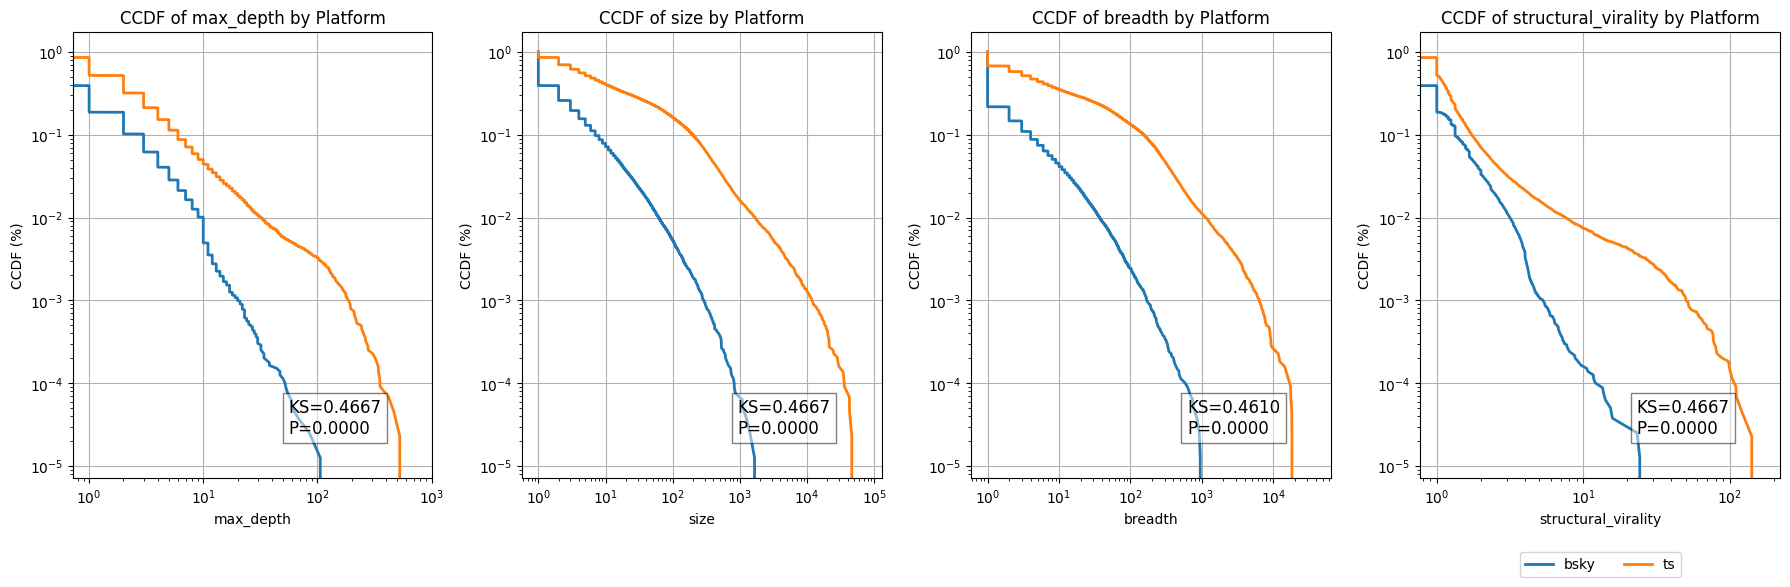

In [50]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = c_df[c_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    c_ks_stat, p_value = c_ks_overall_df.loc[
        c_ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={c_ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

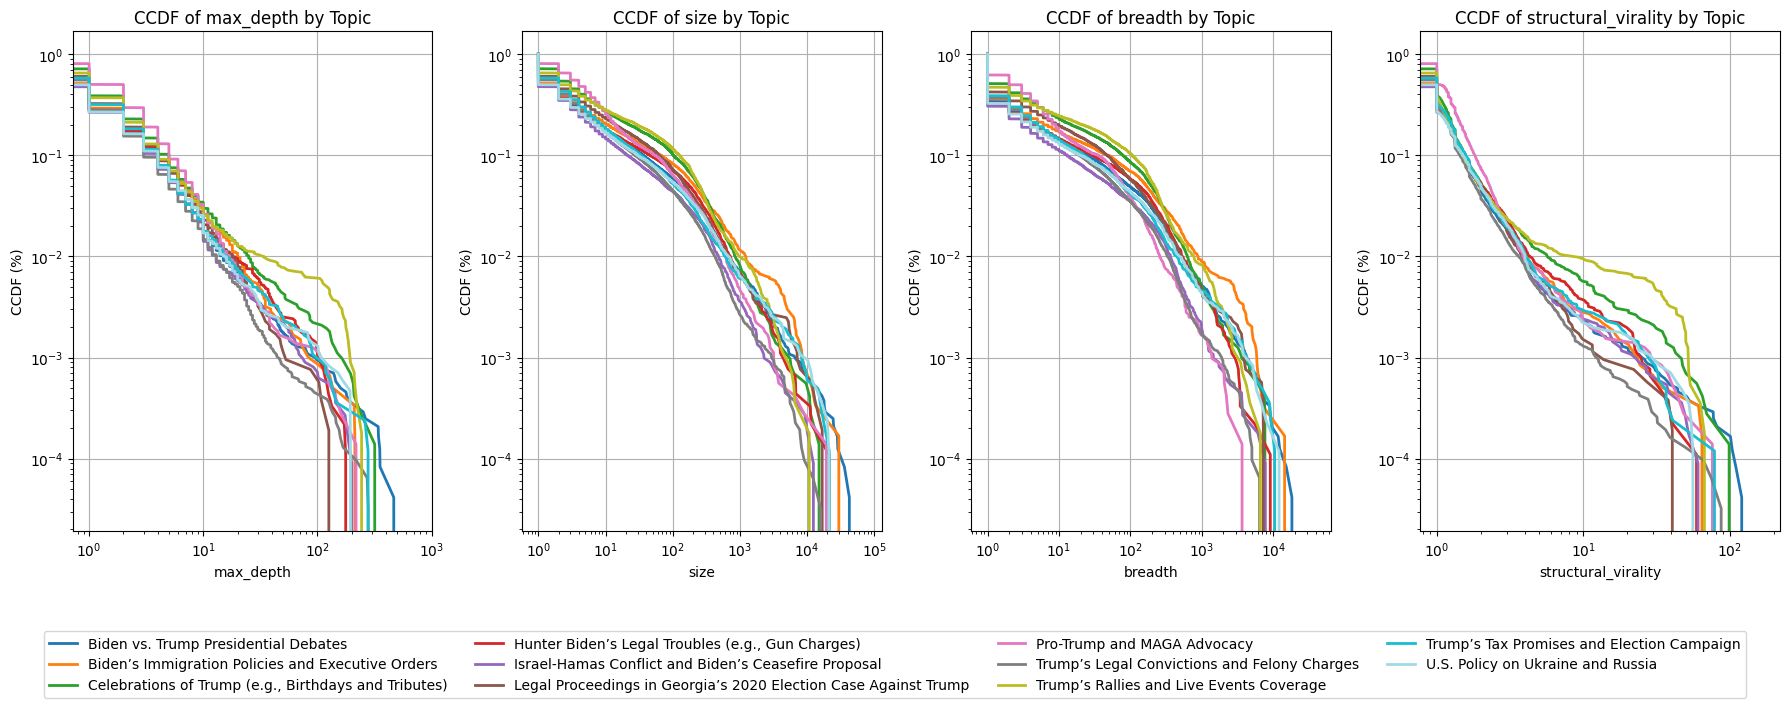

In [51]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(c_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

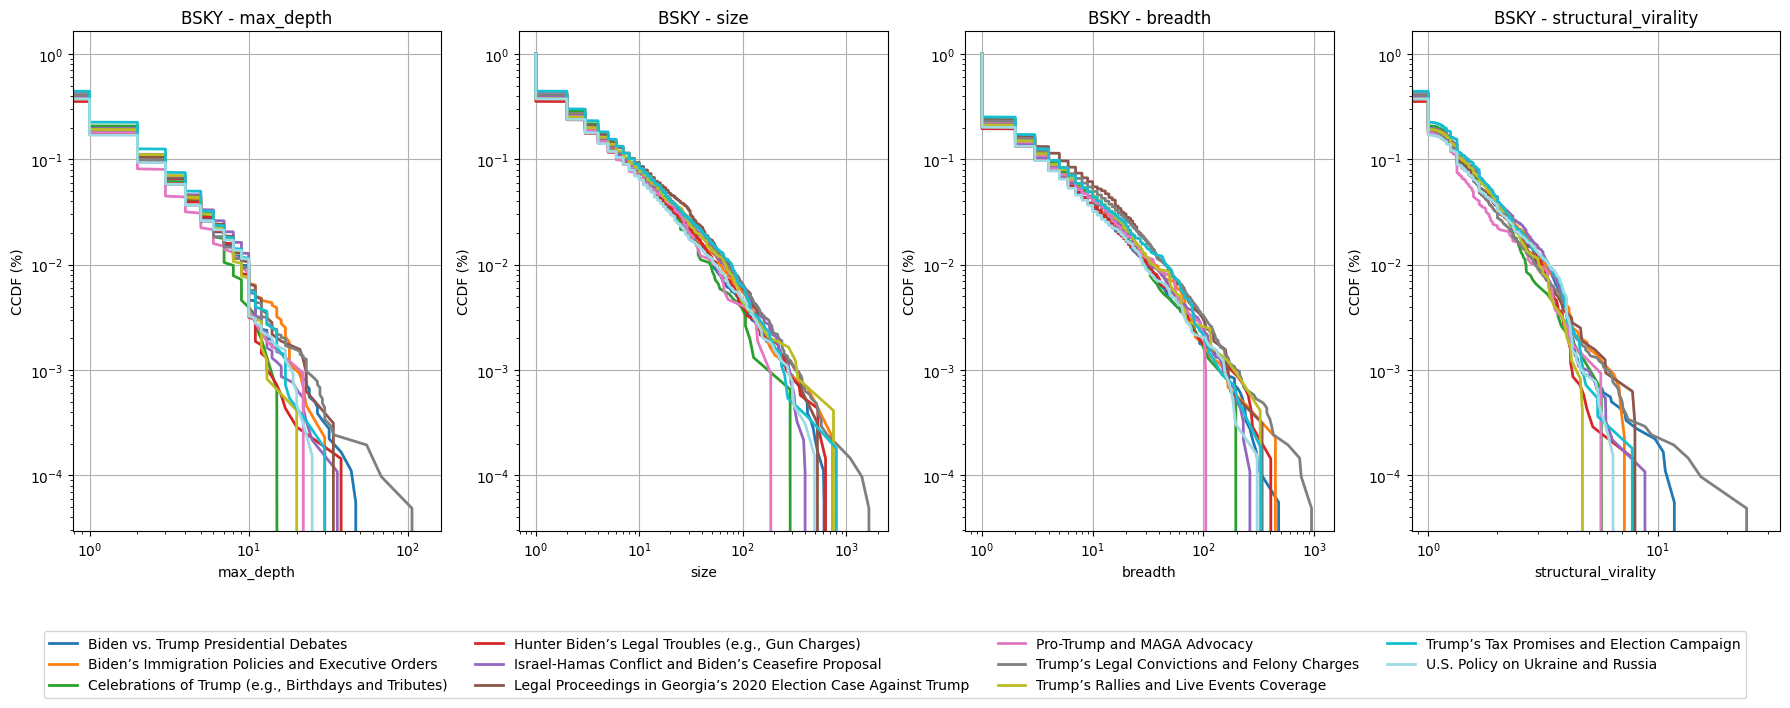

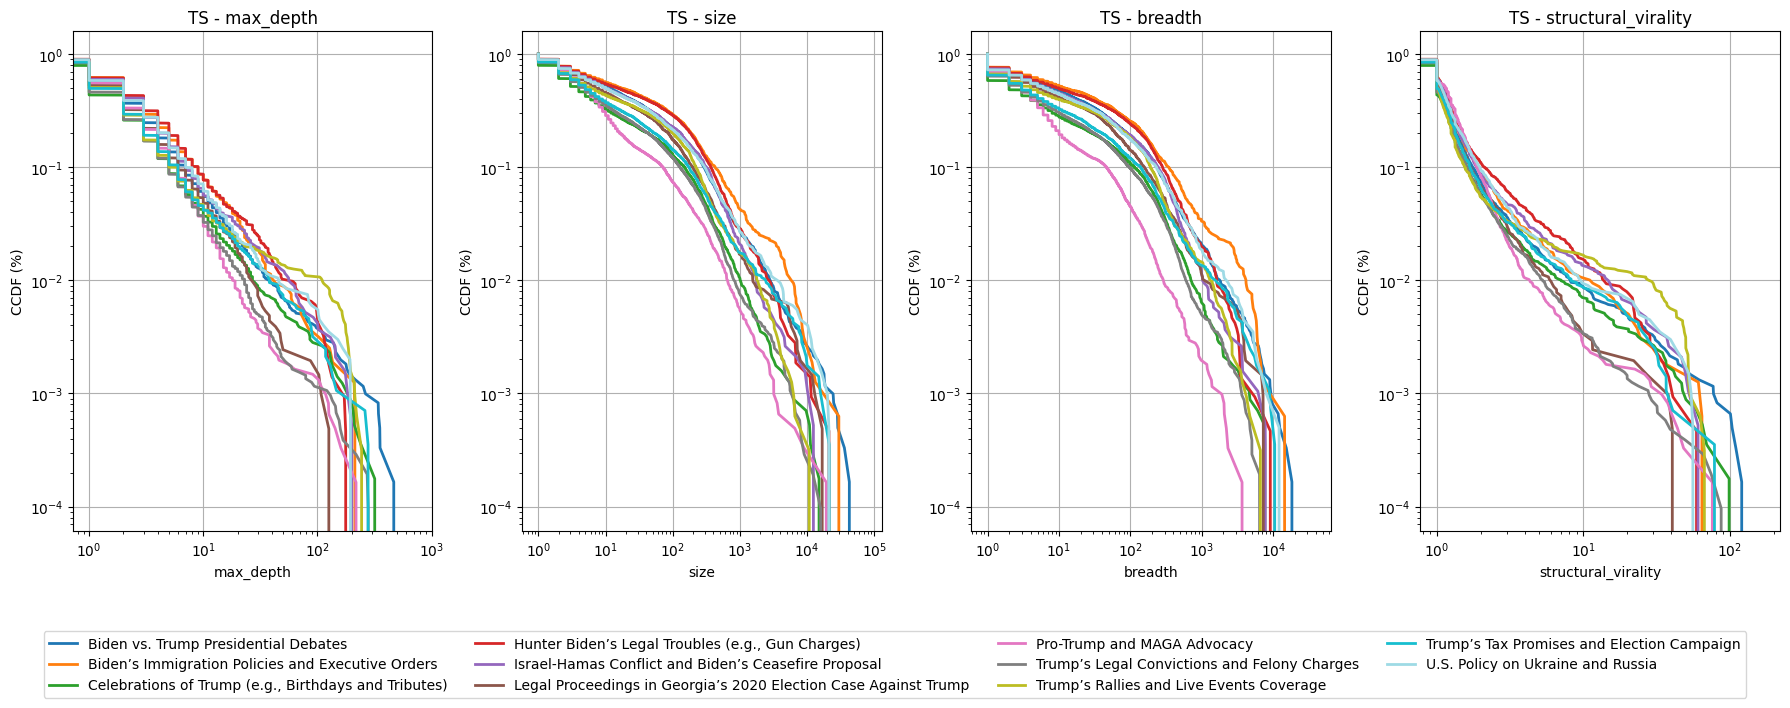

In [52]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = c_df[c_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# Summary

1. Topic-wise comparison: Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.
2. Topic-wise ccdf: 
    1. Reply network: most salient distribution for BlueSky is from presidential debates and same for Truth Social.
    2. Repost network: most salient distribution for BlueSky is from Trump's legal convictions and For Truth Social, it is from presidential debates.
    3. Combined network: as same as repost network, but the Truth Social phenomenon is more pronounced.
3. 191575 out of 747571 for ts and 23138 out of 59813 

# D. Matching the cascades across platforms

## 1. Understand the relationship between the size and other metrics

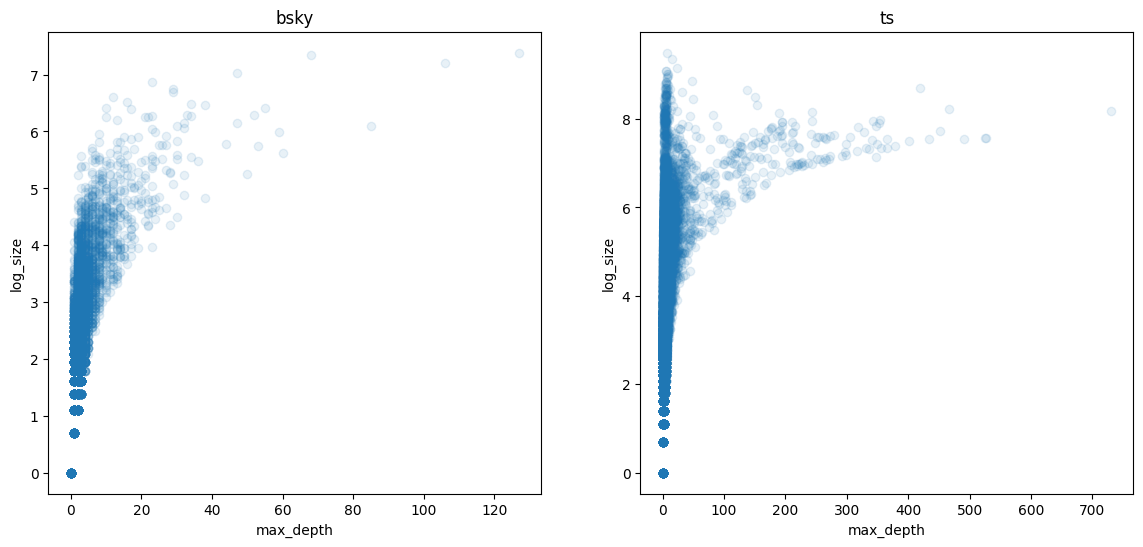

In [ ]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(
    rp_bsky_df["max_depth"], rp_bsky_df["log_size"], label="bsky", alpha=0.1
)
axes[1].scatter(rp_ts_df["max_depth"], rp_ts_df["log_size"], label="ts", alpha=0.1)
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("log_size")
axes[0]
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


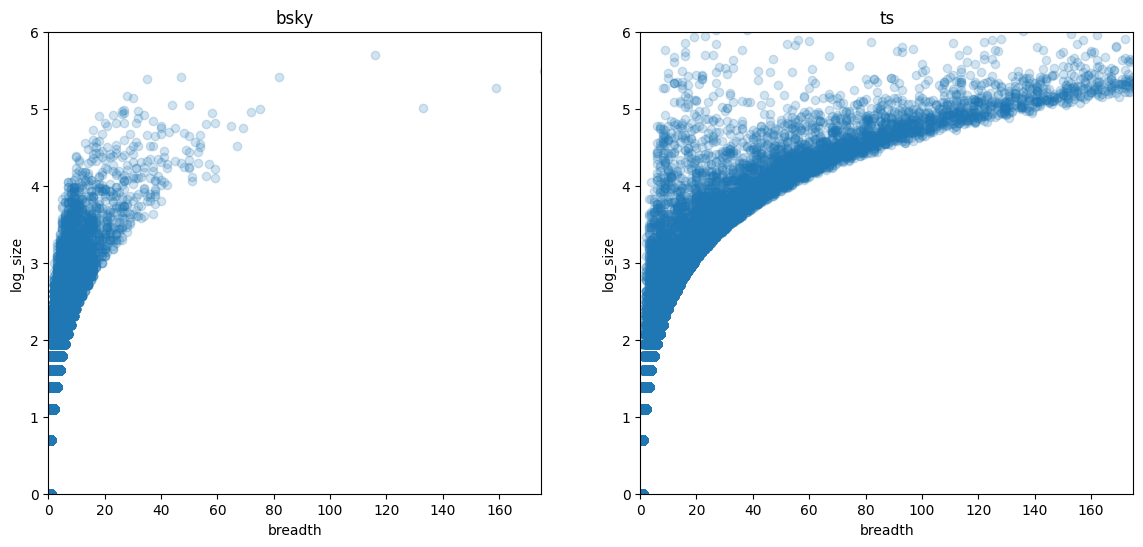

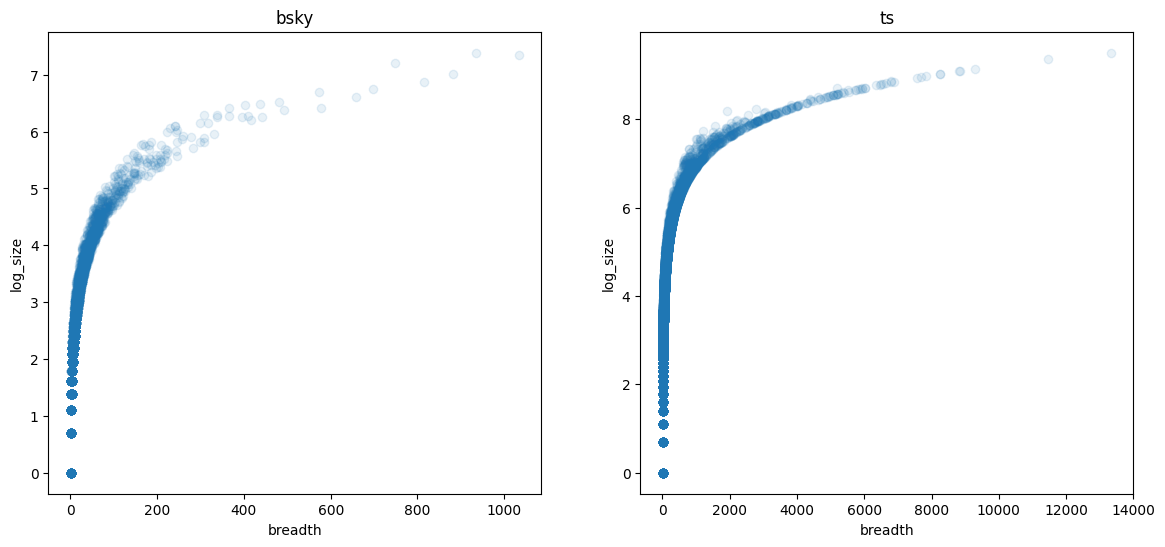

In [36]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(rp_bsky_df["breadth"], rp_bsky_df["log_size"], label="bsky", alpha=0.1)
axes[1].scatter(rp_ts_df["breadth"], rp_ts_df["log_size"], label="ts", alpha=0.1)
axes[0].set_xlabel("breadth")
axes[0].set_ylabel("log_size")
axes[1].set_xlabel("breadth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()

In [6]:
len(ts_df)

43818

In [22]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

# Sort ts_df by size for efficient binary search
ts_df = ts_df.sort_values("size").reset_index()
bsky_df = bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = bsky_df["size"].to_numpy()
ts_sizes = ts_df["size"].to_numpy()
ts_indices = ts_df.index.to_numpy()  # Store original indices

# Store indices of matched records instead of full row data
matched_indices = []
unmatched_size = set()

# Track available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])  # Store index for sampling

# Fast lookup using NumPy binary search
for size in bsky_sizes:
    idx = np.searchsorted(ts_sizes, size)  # Find closest match index

    # Get nearest neighbor within tolerance
    possible_matches = size_to_indices.get(ts_sizes[idx], [])

    # If valid matches are found, sample one
    if possible_matches:
        matched_indices.append(
            random.choice(possible_matches)
        )  # Randomly sample one index
    else:
        unmatched_size.add(size)

# Reconstruct the final DataFrame using the sampled indices
sampled_ts_df = (
    ts_df.loc[matched_indices].reset_index(drop=True)
    if matched_indices
    else pd.DataFrame()
)


In [23]:
sampled_ts_df.shape

(79397, 13)

In [24]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
sampled_ts_df = sampled_ts_df[columns_to_keep].reset_index(drop=True)
# sampled_ts_df.drop_duplicates(inplace=True)
df = pd.concat([bsky_df, sampled_ts_df], ignore_index=True)
df = df.dropna(subset=["topic_label"])

metrics = ["max_depth", "size", "breadth", "structural_virality"]

In [25]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)

In [26]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(
    np.linspace(0, 1, len(sorted(df["topic_label"].unique())))
)  # Use tab20 colormap
sorted_topics = sorted(df["topic_label"].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}


def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data["topic_label"] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(
            sorted_vals,
            ccdf_vals,
            label=f"{topic}",
            linewidth=2,
            color=topic_color_map[topic],
        )
    ax.set_xscale("log")  # Apply log scale to x-axis
    ax.set_yscale("log")
    ax.set_xlabel(metric)
    ax.set_ylabel("CCDF (%)")
    ax.set_title(f"CCDF of {metric} by Topic")
    ax.grid()


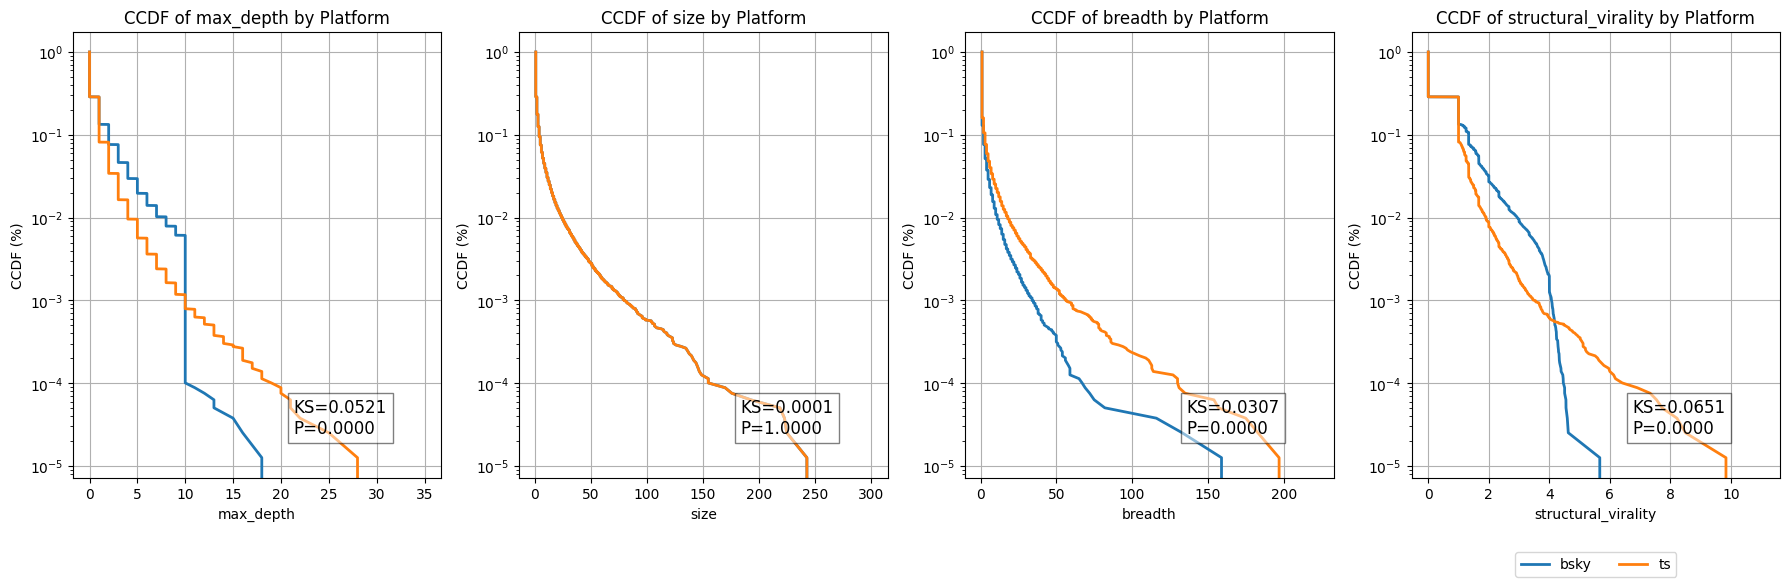

In [27]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    #    axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

Processing CCDFs: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


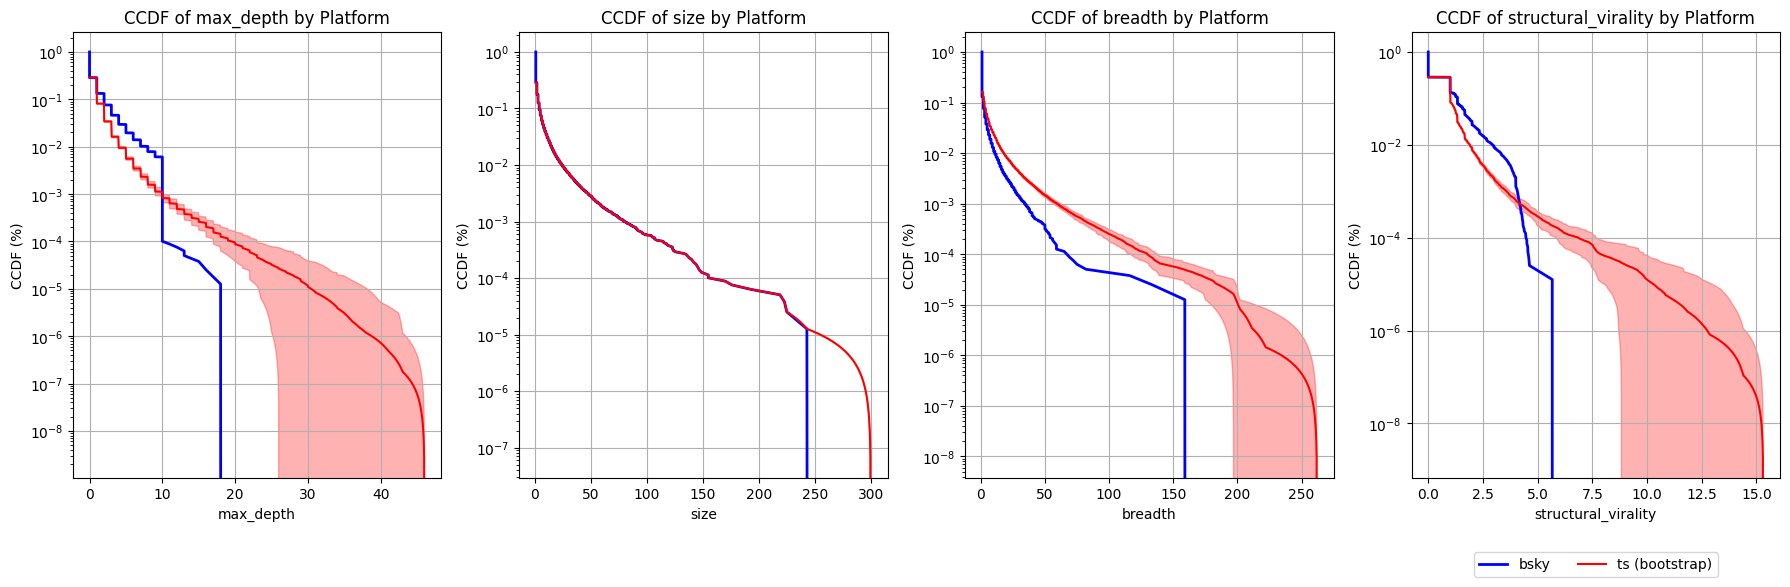

In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import ks_2samp
from tqdm import tqdm

# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)

# Function to compute CCDF
def compute_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf
# Sort ts_df by size for efficient binary search
ts_df = ts_df.sort_values("size").reset_index(drop=True)
bsky_df = bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = bsky_df["size"].to_numpy()
ts_sizes = ts_df["size"].to_numpy()
ts_indices = ts_df.index.to_numpy()

# Store available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])

# Perform bootstrapping
num_bootstrap_samples = 1000
bootstrap_ccdfs = {metric: [] for metric in ["max_depth", "size", "breadth", "structural_virality"]}

for _ in tqdm(range(num_bootstrap_samples), desc="Bootstrapping samples"):
    matched_indices = []
    for size in bsky_sizes:
        idx = np.searchsorted(ts_sizes, size)
        possible_matches = size_to_indices.get(ts_sizes[idx], [])
        if possible_matches:
            matched_indices.append(random.choice(possible_matches))
    if matched_indices:
        sampled_ts_df = ts_df.loc[matched_indices].reset_index(drop=True)
        sampled_ts_df = sampled_ts_df[columns_to_keep]
        
        # Compute CCDF for each metric in the current bootstrap sample
        for metric in bootstrap_ccdfs.keys():
            sample_vals = sampled_ts_df[metric].dropna().to_numpy()
            sorted_vals, ccdf_vals = compute_ccdf(sample_vals)
            bootstrap_ccdfs[metric].append((sorted_vals, ccdf_vals))

# Compute mean and confidence intervals for each metric
ccdf_summary = {}
for metric, samples in tqdm(bootstrap_ccdfs.items(), desc="Processing CCDFs"):
    all_x_vals = [x_vals for x_vals, _ in samples]
    min_x = min(min(x) for x in all_x_vals if len(x) > 0)
    max_x = max(max(x) for x in all_x_vals if len(x) > 0)
    common_x_vals = np.linspace(min_x, max_x, 1000)
    
    interpolated_ccdfs = [
        np.interp(common_x_vals, x_vals, ccdf, left=1.0, right=0.0)
        for x_vals, ccdf in samples
    ]
    interpolated_ccdfs = np.array(interpolated_ccdfs)
    
    ccdf_summary[metric] = {
        "mean": np.mean(interpolated_ccdfs, axis=0),
        "lower": np.percentile(interpolated_ccdfs, 2.5, axis=0),
        "upper": np.percentile(interpolated_ccdfs, 97.5, axis=0),
        "x_vals": common_x_vals
    }

# Plot CCDF comparison with bootstrapped TruthSocial
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for idx, metric in enumerate(ccdf_summary.keys()):
    # Plot BlueSky as usual
    bsky_vals = bsky_df[metric].dropna()
    sorted_vals, ccdf = compute_ccdf(bsky_vals)
    axes[idx].plot(sorted_vals, ccdf, label="bsky", linewidth=2, color='b')
    
    # Plot TruthSocial using bootstrapped method
    summary = ccdf_summary[metric]
    axes[idx].plot(summary["x_vals"], summary["mean"], label="ts (bootstrap)", color='r')
    axes[idx].fill_between(summary["x_vals"], summary["lower"], summary["upper"], color='r', alpha=0.3)
    
    axes[idx].set_yscale("log")
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()



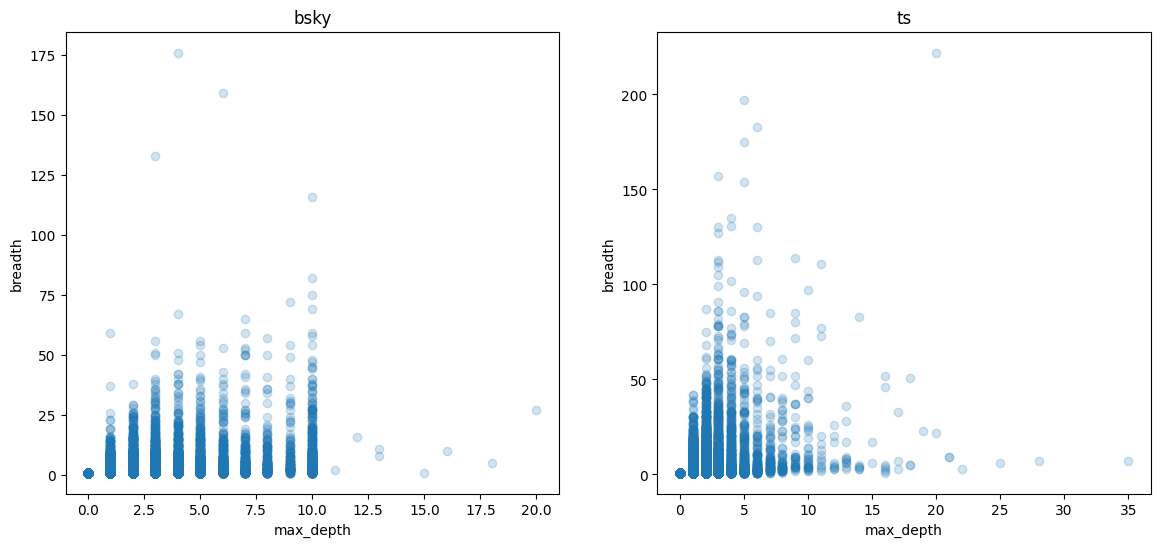

In [28]:
# plot the max depth and mean breadth of the reply

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(bsky_df["max_depth"], bsky_df["breadth"], label="bsky", alpha=0.2)
axes[1].scatter(
    sampled_ts_df["max_depth"], sampled_ts_df["breadth"], label="ts", alpha=0.2
)
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("breadth")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("breadth")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


In [32]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

# Sort rp_ts_df by size for efficient binary search
rp_ts_df = rp_ts_df.sort_values("size").reset_index(drop=True)
rp_bsky_df = rp_bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = rp_bsky_df["size"].to_numpy()
ts_sizes = rp_ts_df["size"].to_numpy()
ts_indices = rp_ts_df.index.to_numpy()  # Store original indices

# Store indices of matched records instead of full row data
matched_indices = []
unmatched_size = set()

# Track available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])  # Store index for sampling

# Fast lookup using NumPy binary search
for size in bsky_sizes:
    idx = np.searchsorted(ts_sizes, size)  # Find closest match index

    # Get nearest neighbor within tolerance
    possible_matches = size_to_indices.get(ts_sizes[idx], [])

    # If valid matches are found, sample one
    if possible_matches:
        matched_indices.append(
            random.choice(possible_matches)
        )  # Randomly sample one index
    else:
        unmatched_size.add(size)

# Reconstruct the final DataFrame using the sampled indices
sampled_rp_ts_df = (
    rp_ts_df.loc[matched_indices].reset_index(drop=True)
    if matched_indices
    else pd.DataFrame()
)


In [30]:
sampled_rp_ts_df.drop_duplicates(inplace=True)

In [33]:
sampled_rp_ts_df.shape

(195616, 13)

In [34]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "structural_virality",
]  # Removed 'structural_virality'
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)
sampled_rp_ts_df = sampled_rp_ts_df[columns_to_keep].reset_index(drop=True)

rp_df = pd.concat([rp_bsky_df, sampled_rp_ts_df], ignore_index=True)
rp_df = rp_df.dropna(subset=["topic_label"])
print(len(rp_df))


391225


In [35]:
# Compute KS statistics for each metric
ks_results = []
metrics = ["max_depth", "size", "breadth", "structural_virality"]
for metric in metrics:
    bsky_vals = rp_df[rp_df["platform"] == "bsky"][metric].dropna()
    ts_vals = rp_df[rp_df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


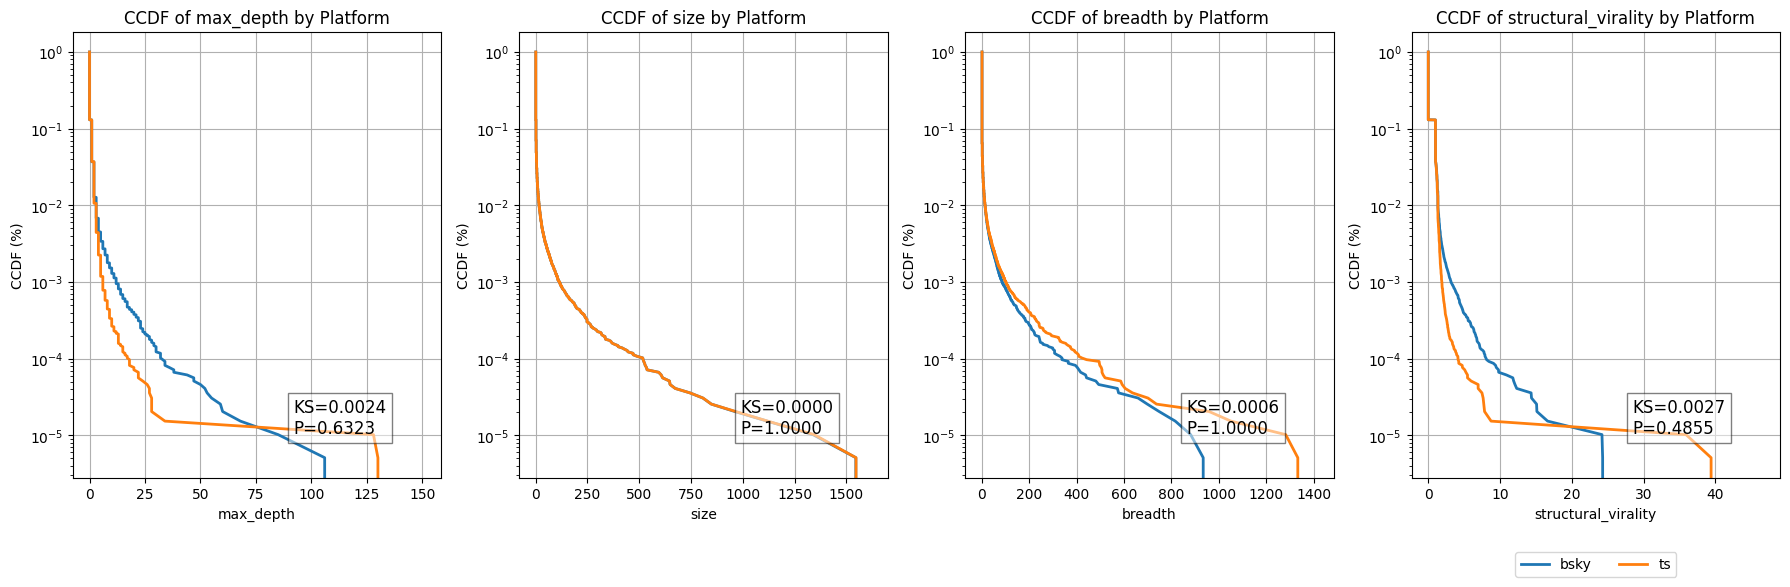

In [36]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = rp_df[rp_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()


Processing CCDFs: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


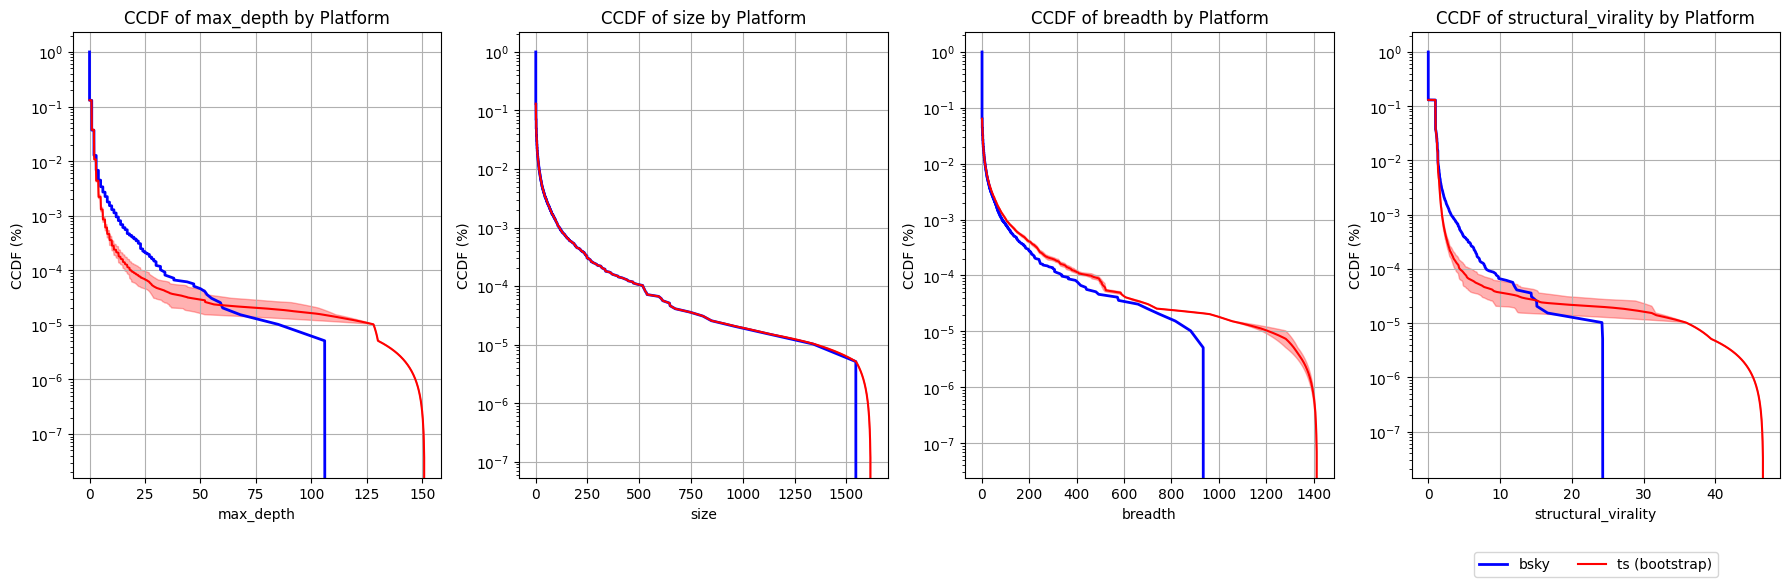

In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import ks_2samp
from tqdm import tqdm

# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)

# Sort rp_ts_df by size for efficient binary search
rp_ts_df = rp_ts_df.sort_values("size").reset_index(drop=True)
rp_bsky_df = rp_bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = rp_bsky_df["size"].to_numpy()
ts_sizes = rp_ts_df["size"].to_numpy()
ts_indices = rp_ts_df.index.to_numpy()

# Store available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])

# Perform bootstrapping
num_bootstrap_samples = 100
bootstrap_ccdfs = {metric: [] for metric in ["max_depth", "size", "breadth", "structural_virality"]}

for _ in tqdm(range(num_bootstrap_samples), desc="Bootstrapping samples"):
    matched_indices = []
    for size in bsky_sizes:
        idx = np.searchsorted(ts_sizes, size)
        possible_matches = size_to_indices.get(ts_sizes[idx], [])
        if possible_matches:
            matched_indices.append(random.choice(possible_matches))
    if matched_indices:
        sampled_rp_ts_df = rp_ts_df.loc[matched_indices].reset_index(drop=True)
        sampled_rp_ts_df = sampled_rp_ts_df[columns_to_keep]
        
        # Compute CCDF for each metric in the current bootstrap sample
        for metric in bootstrap_ccdfs.keys():
            sample_vals = sampled_rp_ts_df[metric].dropna().to_numpy()
            sorted_vals, ccdf_vals = compute_ccdf(sample_vals)
            bootstrap_ccdfs[metric].append((sorted_vals, ccdf_vals))

# Compute mean and confidence intervals for each metric
ccdf_summary = {}
for metric, samples in tqdm(bootstrap_ccdfs.items(), desc="Processing CCDFs"):
    all_x_vals = [x_vals for x_vals, _ in samples]
    min_x = min(min(x) for x in all_x_vals if len(x) > 0)
    max_x = max(max(x) for x in all_x_vals if len(x) > 0)
    common_x_vals = np.linspace(min_x, max_x, 1000)
    
    interpolated_ccdfs = [
        np.interp(common_x_vals, x_vals, ccdf, left=1.0, right=0.0)
        for x_vals, ccdf in samples
    ]
    interpolated_ccdfs = np.array(interpolated_ccdfs)
    
    ccdf_summary[metric] = {
        "mean": np.mean(interpolated_ccdfs, axis=0),
        "lower": np.percentile(interpolated_ccdfs, 2.5, axis=0),
        "upper": np.percentile(interpolated_ccdfs, 97.5, axis=0),
        "x_vals": common_x_vals
    }

# Plot CCDF comparison with bootstrapped TruthSocial
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for idx, metric in enumerate(ccdf_summary.keys()):
    # Plot BlueSky as usual
    bsky_vals = rp_bsky_df[metric].dropna()
    sorted_vals, ccdf = compute_ccdf(bsky_vals)
    axes[idx].plot(sorted_vals, ccdf, label="bsky", linewidth=2, color='b')
    
    # Plot TruthSocial using bootstrapped method
    summary = ccdf_summary[metric]
    axes[idx].plot(summary["x_vals"], summary["mean"], label="ts (bootstrap)", color='r')
    axes[idx].fill_between(summary["x_vals"], summary["lower"], summary["upper"], color='r', alpha=0.3)
    
    axes[idx].set_yscale("log")
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()


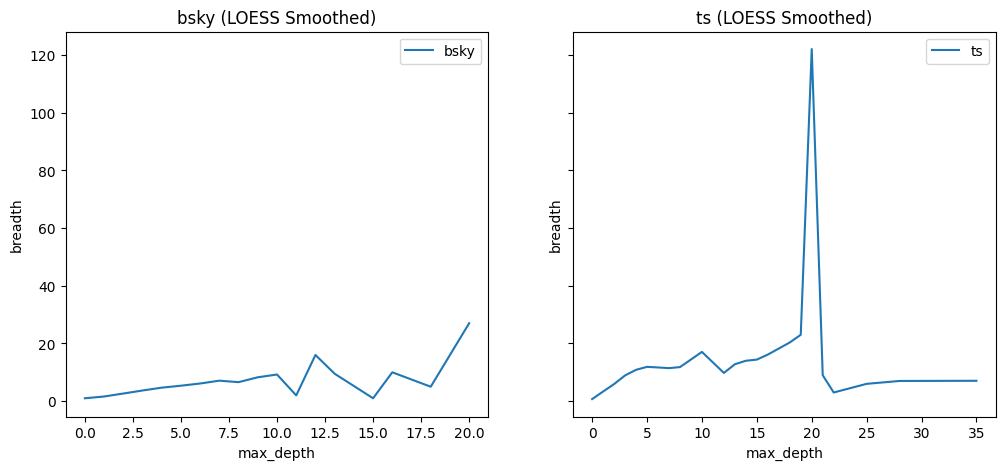

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Assuming 'df' is your DataFrame with 'max_depth', 'breadth', and 'platform' columns
df_bsky = df[df["platform"] == "bsky"]
df_ts = df[df["platform"] == "ts"]

# Compute the mean breadth for each max_depth
bsky_grouped = df_bsky.groupby("max_depth")["breadth"].mean().reset_index()
ts_grouped = df_ts.groupby("max_depth")["breadth"].mean().reset_index()

# Apply LOWESS smoothing (fraction controls smoothing level)
frac = 0.2  # Adjust fraction for smoother or sharper fit
bsky_smooth = lowess(bsky_grouped["breadth"], bsky_grouped["max_depth"], frac=frac)
ts_smooth = lowess(ts_grouped["breadth"], ts_grouped["max_depth"], frac=frac)

# Plot the smoothed data
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].plot(bsky_smooth[:, 0], bsky_smooth[:, 1], linestyle="-", label="bsky")
axes[1].plot(ts_smooth[:, 0], ts_smooth[:, 1], linestyle="-", label="ts")

# Titles and labels
axes[0].set_title("bsky (LOESS Smoothed)")
axes[1].set_title("ts (LOESS Smoothed)")

for ax in axes:
    ax.set_xlabel("max_depth")
    ax.set_ylabel("breadth")
    ax.legend()

plt.show()


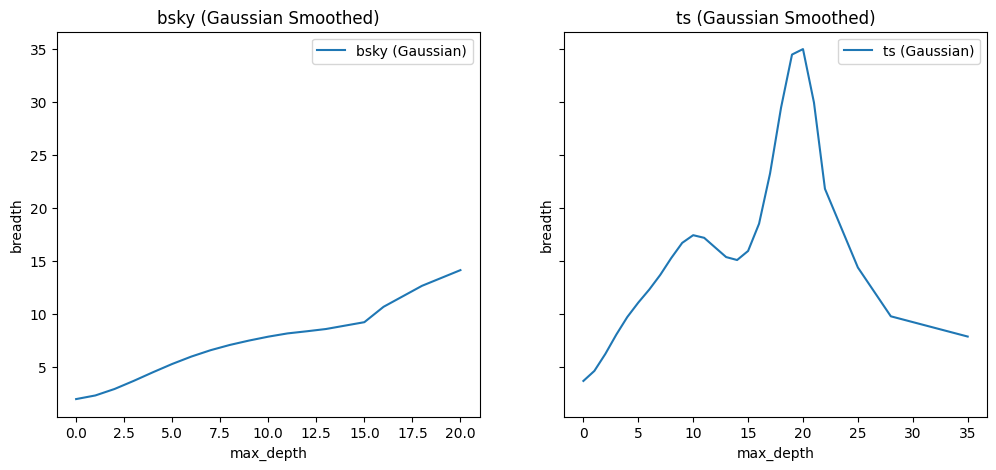

In [38]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing to the grouped means
bsky_smooth_gauss = gaussian_filter1d(bsky_grouped["breadth"], sigma=2)
ts_smooth_gauss = gaussian_filter1d(ts_grouped["breadth"], sigma=2)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].plot(
    bsky_grouped["max_depth"], bsky_smooth_gauss, linestyle="-", label="bsky (Gaussian)"
)
axes[1].plot(
    ts_grouped["max_depth"], ts_smooth_gauss, linestyle="-", label="ts (Gaussian)"
)

# Titles and labels
axes[0].set_title("bsky (Gaussian Smoothed)")
axes[1].set_title("ts (Gaussian Smoothed)")

for ax in axes:
    ax.set_xlabel("max_depth")
    ax.set_ylabel("breadth")
    ax.legend()

plt.show()


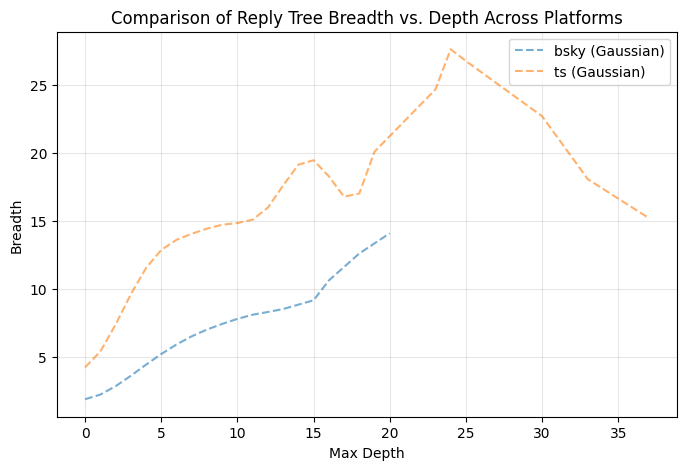

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import gaussian_filter1d

# Assuming 'df' is your DataFrame with 'max_depth', 'breadth', and 'platform' columns
df_bsky = df[df["platform"] == "bsky"]
df_ts = df[df["platform"] == "ts"]

# Compute mean breadth per max_depth
bsky_grouped = df_bsky.groupby("max_depth")["breadth"].mean().reset_index()
ts_grouped = df_ts.groupby("max_depth")["breadth"].mean().reset_index()

# Apply LOESS smoothing
frac = 0.2  # Adjust fraction for smoother or sharper fit
bsky_loess = lowess(bsky_grouped["breadth"], bsky_grouped["max_depth"], frac=frac)
ts_loess = lowess(ts_grouped["breadth"], ts_grouped["max_depth"], frac=frac)

# Apply Gaussian smoothing
bsky_gauss = gaussian_filter1d(bsky_grouped["breadth"], sigma=2)
ts_gauss = gaussian_filter1d(ts_grouped["breadth"], sigma=2)

# Plot both platforms on the same graph
plt.figure(figsize=(8, 5))

# LOESS Smoothed Lines
# plt.plot(bsky_loess[:, 0], bsky_loess[:, 1], linestyle="-", label="bsky (LOESS)", alpha=0.8)
# plt.plot(ts_loess[:, 0], ts_loess[:, 1], linestyle="-", label="ts (LOESS)", alpha=0.8)

# Gaussian Smoothed Lines (dashed for distinction)
plt.plot(
    bsky_grouped["max_depth"],
    bsky_gauss,
    linestyle="--",
    label="bsky (Gaussian)",
    alpha=0.6,
)
plt.plot(
    ts_grouped["max_depth"], ts_gauss, linestyle="--", label="ts (Gaussian)", alpha=0.6
)

# Labels and title
plt.xlabel("Max Depth")
plt.ylabel("Breadth")
plt.title("Comparison of Reply Tree Breadth vs. Depth Across Platforms")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


# E. Normalization

## 1. Normalize the depth and width of the cascades by its size

In [ ]:
bsky_df["bredth_normalized"] = bsky_df["breadth"] / bsky_df["size"]
ts_df["bredth_normalized"] = ts_df["breadth"] / ts_df["size"]
rp_bsky_df["bredth_normalized"] = rp_bsky_df["breadth"] / rp_bsky_df["size"]
rp_ts_df["bredth_normalized"] = rp_ts_df["breadth"] / rp_ts_df["size"]

bsky_df["deepth_normalized"] = bsky_df["max_depth"] / bsky_df["size"]
ts_df["deepth_normalized"] = ts_df["max_depth"] / ts_df["size"]
rp_bsky_df["deepth_normalized"] = rp_bsky_df["max_depth"] / rp_bsky_df["size"]
rp_ts_df["deepth_normalized"] = rp_ts_df["max_depth"] / rp_ts_df["size"]


In [17]:
sum(df["size"] == 1)

75526

In [ ]:
sum(df_rp["size"] == 1)

1321200

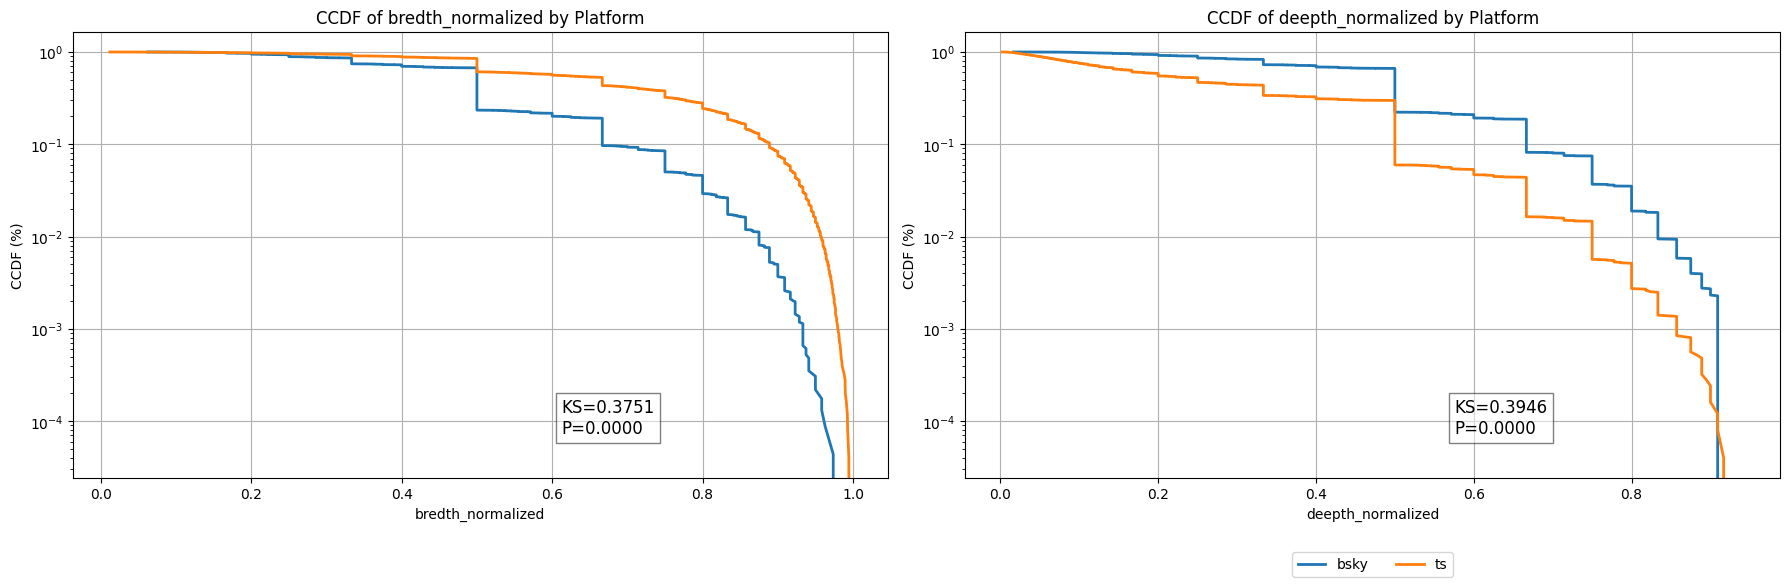

In [21]:
df = pd.concat([bsky_df, ts_df], ignore_index=True)
df = df.loc[df["size"] > 1]
# Compute KS statistics for each metric
ks_results = []
metrics = ["bredth_normalized", "deepth_normalized"]
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)
# plot the ccdf of nomalized bredth and deepth
# Plot CCDF comparison by platform

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(["bredth_normalized", "deepth_normalized"]):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

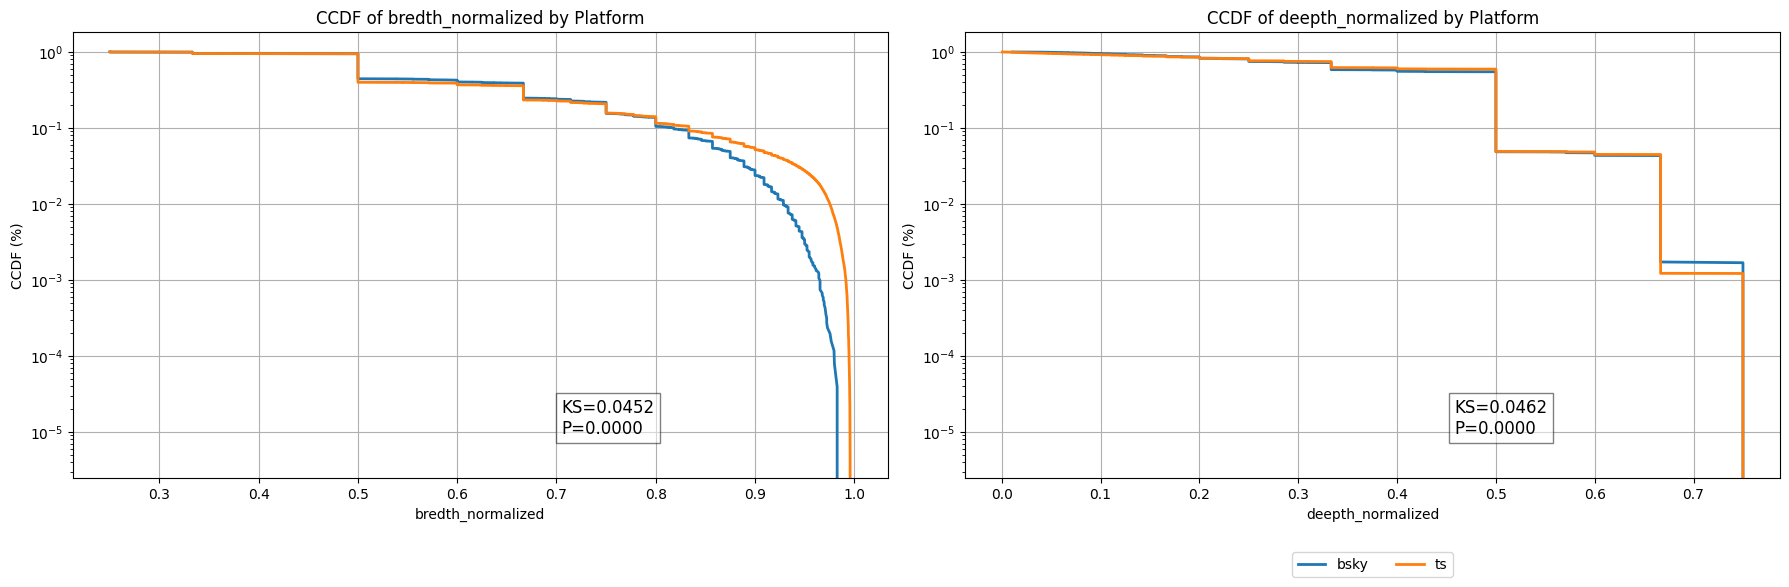

In [20]:
# for repost
df_rp = pd.concat([rp_bsky_df, rp_ts_df], ignore_index=True)
df_rp = df_rp.loc[df_rp["size"] > 1]
# compute ks statistics for each metric
ks_results = []
metrics = ["bredth_normalized", "deepth_normalized"]
for metric in metrics:
    bsky_vals = df_rp[df_rp["platform"] == "bsky"][metric].dropna()
    ts_vals = df_rp[df_rp["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)

# plot the ccdf of nomalized bredth and deepth
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(["bredth_normalized", "deepth_normalized"]):
    for platform in ["bsky", "ts"]:
        values = df_rp[df_rp["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

# F. Null models with Z scores

## 1. Reply Network

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


# Function to compute tree metrics: Breadth and Depth
def compute_tree_metrics(tree):
    levels = {}
    n = len(tree.nodes())
    for node in tree.nodes():
        depth = nx.shortest_path_length(tree, source=0, target=node)
        if depth in levels:
            levels[depth] += 1
        else:
            levels[depth] = 1
    breadth = max(levels.values())  # Max nodes at any depth
    depth = max(levels.keys())  # Max depth from root
    #compute structural virality
    shortest_paths =dict(nx.all_pairs_shortest_path_length(tree))
    total_distance =  sum(
        shortest_paths[i][j] for i in tree.nodes for j in tree.nodes if i != j
    )
    # Normalize
    virality = total_distance / (n * (n - 1)) if n > 1 else 0

    return breadth, depth, virality

# Function to generate null trees
def generate_null_trees(n_nodes, num_null_samples=100):
    from tqdm.auto import tqdm
    # using prufer code to generate random tree
    if n_nodes == 1:
        return np.zeros((num_null_samples, 3))
    if n_nodes == 2:
        return np.zeros((num_null_samples, 3))
    null_metrics = []
    for _ in range(num_null_samples):
        prufer = np.random.randint(0, n_nodes, n_nodes - 2)
        tree = nx.Graph(nx.from_prufer_sequence(prufer))
        breadth, depth, virality = compute_tree_metrics(tree)
        null_metrics.append((breadth, depth, virality))
    return np.array(null_metrics)

# Function to compute Z-score
def compute_z_scores(observed_value, null_values):
    mu = np.mean(null_values)
    sigma = np.std(null_values)
    return (observed_value - mu) / sigma if sigma != 0 else 0  # Avoid division by zero

# Initialize lists to store Z-scores
z_scores_breadth = []
z_scores_depth = []
z_scores_virality = []

# Iterate over dataset rows
from tqdm.auto import tqdm

for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing Z-scores"):
    n_i = int(row["size"])  # Get tree size
    B_i = row["breadth"]
    D_i = row["max_depth"]
    V_i = row["structural_virality"] if row["size"] > 1 else 0  # Avoid log(1) = 0 issue

    # Generate null trees and compute null metrics
    null_metrics = generate_null_trees(n_i)
    null_breadths = null_metrics[:, 0]
    null_depths = null_metrics[:, 1]
    null_virality = null_metrics[:, 2]

    # Compute Z-scores
    Z_B_i = compute_z_scores(B_i, null_breadths)
    Z_D_i = compute_z_scores(D_i, null_depths)
    Z_V_i = compute_z_scores(V_i, null_virality)

    # Store results
    z_scores_breadth.append(Z_B_i)
    z_scores_depth.append(Z_D_i)
    z_scores_virality.append(Z_V_i)

# Add Z-scores to the DataFrame
df["Z_breadth"] = z_scores_breadth
df["Z_depth"] = z_scores_depth
df["Z_virality"] = z_scores_virality

# Save processed data
df.to_csv("z_score_results.csv", index=False)

# Function to plot CCDF
def plot_ccdf(data, title, xlabel, platform=None):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    plt.figure(figsize=(6, 4))
    plt.plot(sorted_data, ccdf, marker='o', linestyle='-', markersize=4, label=platform if platform else "All Platforms")
    plt.xlabel(xlabel)
    plt.ylabel('CCDF')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# Plot CCDFs for each platform separately
for platform in df["platform"].unique():
    df_platform = df[df["platform"] == platform]
    plot_ccdf(df_platform["Z_breadth"], f"CCDF of Z-scores (Breadth) - {platform}", "Z-score (Breadth)", platform)
    plot_ccdf(df_platform["Z_depth"], f"CCDF of Z-scores (Depth) - {platform}", "Z-score (Depth)", platform)
    plot_ccdf(df_platform["Z_virality"], f"CCDF of Z-scores (Virality) - {platform}", "Z-score (Virality)", platform)


Computing Z-scores:   0%|          | 0/123210 [00:00<?, ?it/s]

In [ ]:
null_metrics

array([[1, 1]])

# G. Empirical distribution

In [83]:
# Add parisenship
with open('../data/ts_post_to_label.json', 'r') as f:
    ts_post_to_label = json.load(f)

with open('../data/bsky_post_to_label.json', 'r') as f:
    bsky_post_to_label = json.load(f)

In [110]:
df = pd.concat([bsky_df, ts_df], ignore_index=True)
df['partisanship'] = None
for i, row in df.iterrows():
    if row['platform'] == 'ts':
        post_to_label = ts_post_to_label
    else:
        post_to_label = bsky_post_to_label
    try:
        label = post_to_label[row['post']]
    except:
        label = 'center'
    df.loc[i, 'partisanship'] = label
ts_df = df[df['platform'] == 'ts']
bsky_df = df[df['platform'] == 'bsky']

In [10]:
#pandas display width
pd.set_option('max_colwidth', 500)
bsky_df.sort_values(["max_depth",'size'], ascending=False)[['index','max_depth','size']].head(20)

index  max_depth   size
432    at://did:plc:ovyajbnegrir2ddtwfhijiob/app.bsky.feed.post/3ktsywnjwvk2b       20.0  124.0
47758  at://did:plc:kc6b7l5qnaylgnrkpo4apnms/app.bsky.feed.post/3kvwe5yak7w2w       18.0   46.0
64934  at://did:plc:bysafgct2huunehkyuqiga67/app.bsky.feed.post/3kugvvedmic22       16.0   79.0
13852  at://did:plc:qmekyv6zwpfub2nlgdmx6nsg/app.bsky.feed.post/3kutrx7xplc2o       15.0   16.0
6310   at://did:plc:pjiafkey2cokiupsxpswqlk7/app.bsky.feed.post/3ktuwdsqnyy2k       13.0   57.0
10947  at://did:plc:2ylgbet7hkz6ntdh6eljnsri/app.bsky.feed.post/3kvoikofizc26       13.0   44.0
25744  at://did:plc:wcmdstkjsrghcsa6e76kocbs/app.bsky.feed.post/3ku6o7n65pm26       12.0   99.0
10363  at://did:plc:q5xvqdmbpul3fr5e2r7a4gpq/app.bsky.feed.post/3kujbhna3ky2m       11.0   13.0
6517   at://did:plc:6hit5rjdbmlnscmuk4bbtmuc/app.bsky.feed.post/3kw5rqh4bxq2t       10.0  300.0
2594   at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky.feed.post/3ktrwwa2zu22u       10.0  225.0
6363   at://did:plc:pbvdchux22p3dblf47xgtq3m/app.bsky.feed.post/3kw5vadoxkv2q       10.0  223.0
5315   at://did:plc:p5yoii26kayabauhkym3vtms/app.bsky.feed.post/3ktqkw24qcw25       10.0  219.0
13452  at://did:plc:ayutykgvyf4x7ev5ornltyzz/app.bsky.feed.post/3kuu3nyn2h22l       10.0  176.0
6634   at://did:plc:6hit5rjdbmlnscmuk4bbtmuc/app.bsky.feed.post/3kugnpnqphs2a       10.0  170.0
45191  at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky.feed.post/3ku2fbkujcy2k       10.0  155.0
10533  at://did:plc:izxpomdyri45gzhppiiyattq/app.bsky.feed.post/3kw3xjhq7ix2g       10.0  147.0
12772  at://did:plc:yxavlmxjv2j2nwvjesmq5ogl/app.bsky.feed.post/3kvyymybpo52y       10.0  146.0
8049   at://did:plc:z3vj3sznbplg35cnfx4dtvss/app.bsky.feed.post/3ku6shwqokc24       10.0  145.0
22435  at://did:plc:swgxwbir4rrimj57pf75jckf/app.bsky.feed.post/3kvfoa27ymr2c       10.0  144.0
4266   at://did:plc:on5oeywiqx32fh2zau473wz6/app.bsky.feed.post/3ktqfe5tupj2p       10.0  141.0

In [66]:
# log the size for bsky_df and ts_df
bsky_df["log_size"] = np.log10(bsky_df["size"])
ts_df["log_size"] = np.log10(ts_df["size"])
rp_bsky_df["log_size"] = np.log10(rp_bsky_df["size"])
rp_ts_df["log_size"] = np.log10(rp_ts_df["size"])


In [70]:
ts_df.loc[(ts_df['log_size']>3) & (ts_df['breadth']<500)]

platform                                        topic_label  max_depth  \
64          ts         Trump’s Tax Promises and Election Campaign       14.0   
197         ts           Trump’s Rallies and Live Events Coverage       73.0   
1275        ts       Trump’s Legal Convictions and Felony Charges       35.0   
1856        ts                        Pro-Trump and MAGA Advocacy       23.0   
2296        ts                  U.S. Policy on Ukraine and Russia       72.0   
2402        ts                        Pro-Trump and MAGA Advocacy      143.0   
2425        ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       60.0   
2491        ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       53.0   
3157        ts  Legal Proceedings in Georgia’s 2020 Election C...       48.0   
3252        ts           MAGA and Pro-Trump Hashtags and Advocacy       19.0   
3394        ts       Trump’s Legal Convictions and Felony Charges       69.0   
3566        ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       23.0   
4412        ts               Biden vs. Trump Presidential Debates       12.0   
5483        ts  Celebrations of Trump (e.g., Birthdays and Tri...       20.0   
5577        ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       73.0   
5912        ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       27.0   
6878        ts       Trump’s Legal Convictions and Felony Charges      100.0   
7528        ts           MAGA and Pro-Trump Hashtags and Advocacy      103.0   
7811        ts                        Pro-Trump and MAGA Advocacy      114.0   
7828        ts                  U.S. Policy on Ukraine and Russia      125.0   
8454        ts       Trump’s Legal Convictions and Felony Charges       89.0   
8728        ts  Biden’s Immigration Policies and Executive Orders       24.0   
10357       ts  Celebrations of Trump (e.g., Birthdays and Tri...       83.0   
16777       ts                        Pro-Trump and MAGA Advocacy      124.0   
22817       ts       Trump’s Legal Convictions and Felony Charges       40.0   
23960       ts                  U.S. Policy on Ukraine and Russia      113.0   
37032       ts       Trump’s Legal Convictions and Felony Charges       79.0   
42677       ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...      175.0   
42734       ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       64.0   
42764       ts                        Pro-Trump and MAGA Advocacy      218.0   
42765       ts               Biden vs. Trump Presidential Debates      143.0   
42871       ts  Biden’s Immigration Policies and Executive Orders       76.0   
42958       ts         Trump’s Tax Promises and Election Campaign      278.0   
42964       ts  Legal Proceedings in Georgia’s 2020 Election C...       86.0   
43034       ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       96.0   
43224       ts               Biden vs. Trump Presidential Debates       78.0   

          size  breadth               index  structural_virality  log_size  
64      1442.0    480.0  112622522124430007             2.750062  3.158965  
197     1671.0    314.0  112589152595102749            22.819954  3.222976  
1275    1189.0    377.0  112574848459805958            10.432626  3.075182  
1856    1909.0    462.0  112549766057360253             4.473496  3.280806  
2296   12594.0    404.0  112621173765349628            19.632883  4.100164  
2402    5994.0    141.0  112606193339470212            48.779480  3.777717  
2425    1647.0     76.0  112581337812199496            15.932091  3.216694  
2491    1373.0    387.0  112582284433957075            12.558565  3.137671  
3157    1150.0    364.0  112574856215056848            11.033213  3.060698  
3252    1131.0     99.0  112634443839740794             5.534932  3.053463  
3394    4151.0    127.0  112583333051221274            20.054667  3.618153  
3566    1041.0    281.0  112605211646750554             4.402237  3.017451  
4412    1025.0    458.0  112565088736547518 

/tmp/ipykernel_3146454/465586773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['breadth_size_ratio'] = ts_df['breadth']/ts_df['size']


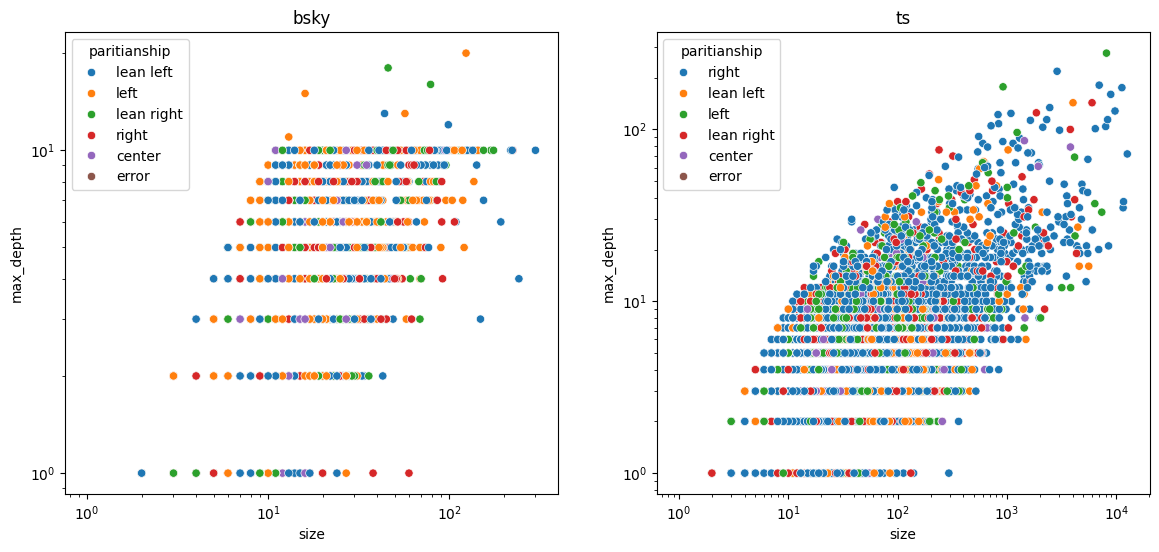

In [109]:
# Plot the scatter plot for size and depth for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ts_df['breadth_size_ratio'] = ts_df['breadth']/ts_df['size']

sns.scatterplot(data=bsky_df, x='size', y='max_depth', ax=axes[0], hue='paritianship')
sns.scatterplot(data=ts_df, x='size', y='max_depth', ax=axes[1], hue='paritianship')
axes[0].set_xlabel("size")
axes[0].set_ylabel("max_depth")
axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("size")
axes[1].set_ylabel("max_depth")

axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


/tmp/ipykernel_3146454/433238408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_size'] = np.log10(df['size'].replace(0, np.nan))  # Avoid log(0)
/tmp/ipykernel_3146454/433238408.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_depth'] = np.log10(df['max_depth'].replace(0, np.nan))  # Avoid log(0)
/tmp/ipykernel_3146454/433238408.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

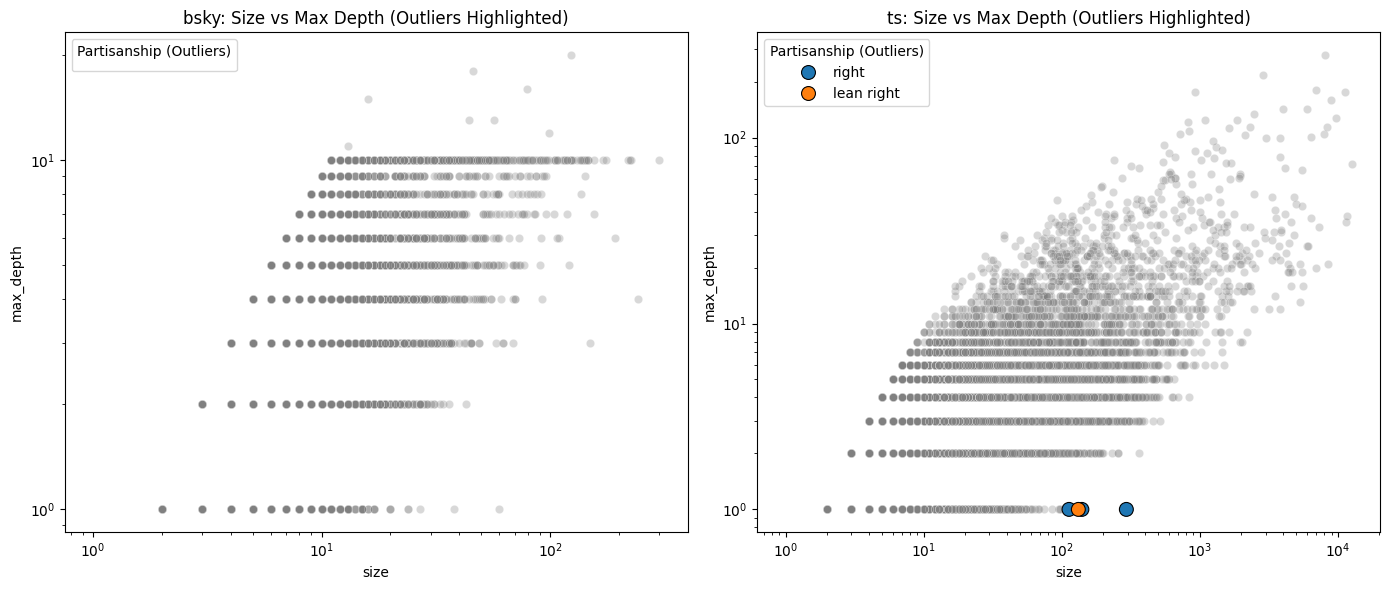

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define expected depth given size (log-binned median)
def expected_depth(df):
    df['log_size'] = np.log10(df['size'].replace(0, np.nan))  # Avoid log(0)
    df['log_depth'] = np.log10(df['max_depth'].replace(0, np.nan))  # Avoid log(0)
    
    # Bin size logarithmically, then compute median depth per bin
    df['size_bin'] = pd.qcut(df['log_size'], q=10, duplicates='drop')  # 10 bins
    depth_median = df.groupby('size_bin')['log_depth'].median()

    # Convert bins to numeric expected depth values
    df['expected_depth'] = df['size_bin'].map(depth_median).astype(float)  # Convert categorical to numeric

    return df

bsky_df = expected_depth(bsky_df)
ts_df = expected_depth(ts_df)

# Identify outliers: Large size but shallower than expected depth
def identify_outliers(df):
    return df[(df['size'] > 100) & (df['log_depth'] < (df['expected_depth'] - 0.5))]  # Deviation threshold

bsky_outliers = identify_outliers(bsky_df)
ts_outliers = identify_outliers(ts_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot all points in gray
sns.scatterplot(data=bsky_df, x="size", y="max_depth", ax=axes[0], color='gray', alpha=0.3)
sns.scatterplot(data=ts_df, x="size", y="max_depth", ax=axes[1], color='gray', alpha=0.3)

# Highlight outliers with partisanship color
sns.scatterplot(data=bsky_outliers, x="size", y="max_depth", ax=axes[0], hue='partisanship', s=100, edgecolor='black', palette="tab10")
sns.scatterplot(data=ts_outliers, x="size", y="max_depth", ax=axes[1], hue='partisanship', s=100, edgecolor='black', palette="tab10")

# Set log scales
for ax in axes:
    ax.set(xscale="log", yscale="log")
    ax.legend(title="Partisanship (Outliers)", loc="upper left")

# Titles and labels
axes[0].set_title("bsky: Size vs Max Depth (Outliers Highlighted)")
axes[1].set_title("ts: Size vs Max Depth (Outliers Highlighted)")

plt.tight_layout()
plt.show()


/tmp/ipykernel_3146454/4282525217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['breadth_size_ratio'] = ts_df['breadth'] / ts_df['size']
/tmp/ipykernel_3146454/4282525217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsky_df['breadth_size_ratio'] = bsky_df['breadth'] / bsky_df['size']
/tmp/ipykernel_3146454/4282525217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

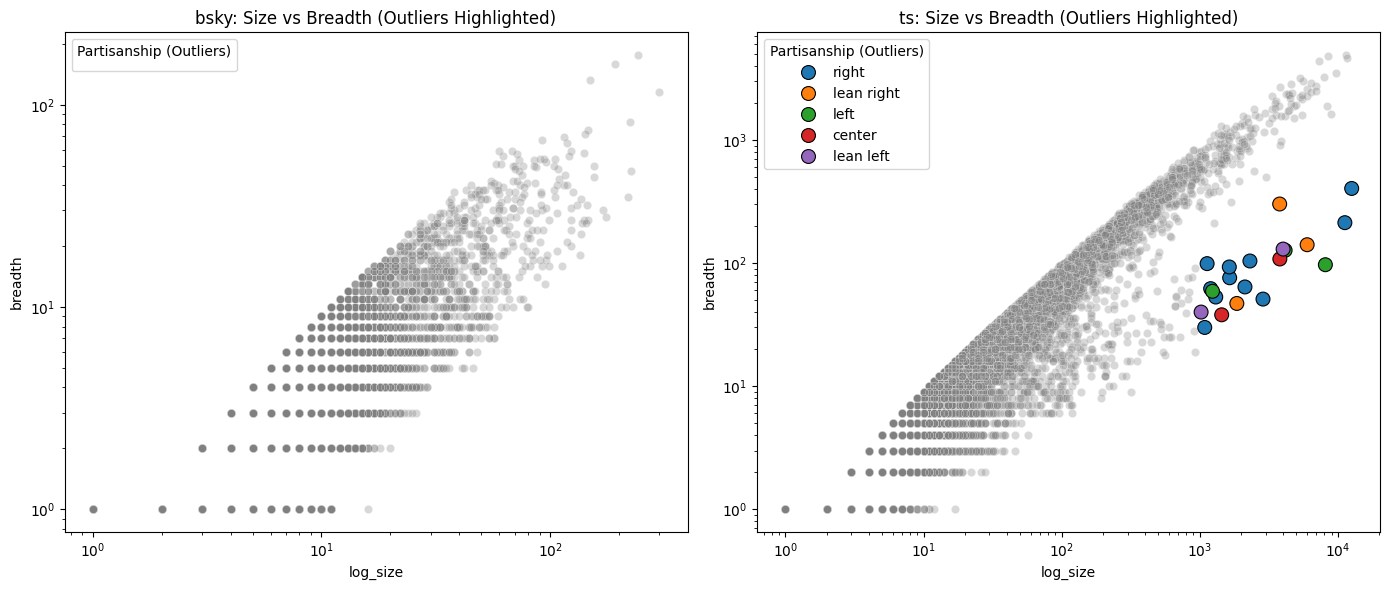

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute breadth-size ratio
ts_df['breadth_size_ratio'] = ts_df['breadth'] / ts_df['size']
bsky_df['breadth_size_ratio'] = bsky_df['breadth'] / bsky_df['size']

# Define outliers
bsky_df['outlier'] = 'no'
bsky_df.loc[(bsky_df['size'] > 100) & (bsky_df['breadth_size_ratio'] < 0.1), 'outlier'] = 'yes'

ts_df['outlier'] = 'no'
ts_df.loc[(ts_df['size'] > 1000) & (ts_df['breadth_size_ratio'] < 0.1), 'outlier'] = 'yes'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot non-outliers in gray
sns.scatterplot(data=bsky_df[bsky_df['outlier'] == 'no'], x="size", y="breadth", ax=axes[0], color='gray', alpha=0.3)
sns.scatterplot(data=ts_df[ts_df['outlier'] == 'no'], x="size", y="breadth", ax=axes[1], color='gray', alpha=0.3)

# Highlight outliers with partisanship colors
sns.scatterplot(data=bsky_df[bsky_df['outlier'] == 'yes'], x="size", y="breadth", ax=axes[0], hue='partisanship', s=100, edgecolor='black', palette="tab10")
sns.scatterplot(data=ts_df[ts_df['outlier'] == 'yes'], x="size", y="breadth", ax=axes[1], hue='partisanship', s=100, edgecolor='black', palette="tab10")

# Set log scales
for ax in axes:
    ax.set(xscale="log", yscale="log")
    ax.set_xlabel("log_size")
    ax.set_ylabel("breadth")
    ax.legend(title="Partisanship (Outliers)", loc="upper left")



# Titles
axes[0].set_title("bsky: Size vs Breadth (Outliers Highlighted)")
axes[1].set_title("ts: Size vs Breadth (Outliers Highlighted)")

plt.tight_layout()
plt.show()


In [81]:
ts_df[ts_df['outlier'] == 'yes']

platform                                        topic_label  max_depth  \
2296        ts                  U.S. Policy on Ukraine and Russia       72.0   
2402        ts                        Pro-Trump and MAGA Advocacy      143.0   
2425        ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       60.0   
3252        ts           MAGA and Pro-Trump Hashtags and Advocacy       19.0   
3394        ts       Trump’s Legal Convictions and Felony Charges       69.0   
6878        ts       Trump’s Legal Convictions and Felony Charges      100.0   
7528        ts           MAGA and Pro-Trump Hashtags and Advocacy      103.0   
7811        ts                        Pro-Trump and MAGA Advocacy      114.0   
7828        ts                  U.S. Policy on Ukraine and Russia      125.0   
8454        ts       Trump’s Legal Convictions and Felony Charges       89.0   
16777       ts                        Pro-Trump and MAGA Advocacy      124.0   
23960       ts                  U.S. Policy on Ukraine and Russia      113.0   
37032       ts       Trump’s Legal Convictions and Felony Charges       79.0   
42677       ts  Israel-Hamas Conflict and Biden’s Ceasefire Pr...      175.0   
42734       ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       64.0   
42764       ts                        Pro-Trump and MAGA Advocacy      218.0   
42765       ts               Biden vs. Trump Presidential Debates      143.0   
42871       ts  Biden’s Immigration Policies and Executive Orders       76.0   
42958       ts         Trump’s Tax Promises and Election Campaign      278.0   
42964       ts  Legal Proceedings in Georgia’s 2020 Election C...       86.0   
43034       ts  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       96.0   

          size  breadth               index  structural_virality  log_size  \
2296   12594.0    404.0  112621173765349628            19.632883  4.100164   
2402    5994.0    141.0  112606193339470212            48.779480  3.777717   
2425    1647.0     76.0  112581337812199496            15.932091  3.216694   
3252    1131.0     99.0  112634443839740794             5.534932  3.053463   
3394    4151.0    127.0  112583333051221274            20.054667  3.618153   
6878    3791.0    302.0  112536097676037581            31.472414  3.578754   
7528    2125.0     64.0  112555249959473464            29.335346  3.327359   
7811    2309.0    104.0  112532652931059624            26.601416  3.363424   
7828    1856.0     47.0  112545997255680783            41.635833  3.268578   
8454    1306.0     53.0  112537941893810183            29.422315  3.115943   
16777   1087.0     30.0  112650237843043352            39.981459  3.036230   
23960   1637.0     93.0  112578048741607813            39.751170  3.214049   
37032   3802.0    108.0  112577348380656551            21.739121  3.580012   
42677  11242.0    213.0  112588259076987596            49.714470  4.050844   
42734   1200.0     62.0  112653017786517872            21.924098  3.079181   
42764   2871.0     51.0  112600534041960237            75.451770  3.458033   
42765   4015.0    130.0  112638647588424202            38.334035  3.603686   
42871   1023.0     40.0  112577319669387589            23.580288  3.009876   
42958   8122.0     97.0  112556547330528263            78.818273  3.909663   
42964   1442.0     38.0  112552415749422449            26.650216  3.158965   
43034   1237.0     59.0  112657707284858985            37.707217  3.092370   

      outlier  breadth_size_ratio  
2296      yes            0.032079  
2402      yes            0.023524  
2425      yes            0.046145  
3252      yes            0.087533  
3394      yes            0.030595  
6878      yes            0.079662  
7528      yes            0.030118  
7811      yes            0.045041  
7828      yes            0.025323  
8454      yes            0.040582  
16777     yes            0.027599  
23960     yes            0.056811  
37032     yes            0.028406  
42677     yes           

In [23]:
ts_df['breadth_size_ratio'] = ts_df["breadth"]/ts_df["size"]

In [24]:
ts_df.sort_values(["size","breadth_size_ratio"], ascending=False).head(10)

index  max_depth     size  breadth  structural_virality  \
2296   112621173765349628       72.0  12594.0    404.0            19.632883   
13131  112644111233618072       38.0  11642.0   4605.0             8.233657   
11570  112673301719650670       35.0  11531.0   4900.0             3.236402   
42677  112588259076987596      175.0  11242.0    213.0            49.714470   
542    112632701426261593      128.0   9722.0   3521.0            32.166800   
4338   112571273082033339      160.0   8889.0   1630.0            47.626109   
8288   112532453963389112       21.0   8492.0   4810.0             2.347361   
5117   112558802830902501      114.0   8324.0   1876.0            32.982066   
42958  112556547330528263      278.0   8122.0     97.0            78.818273   
1093   112593884606525883      104.0   7993.0   3252.0            26.608677   

         reach                                               post  \
2296   12594.0  FALSE. The Mueller report confirmed that Russi...   
13131  11642.0  Nobody can ever trust Fox News, and I am one o...   
11570  11531.0  DRUG TEST FOR CROOKED JOE BIDEN??? I WOULD, AL...   
42677  11242.0  Biden watched him get ready to do it and liter...   
542     9722.0  ANOTHER one of Crooked Joe Biden's Illegal Imm...   
4338    8889.0  It is a Total and Complete American Tragedy th...   
8288    8492.0  PRESS CONFERENCE TOMORROW MORNING AT 11:00 A.M...   
5117    8324.0  Weak Joe Biden is only now scrambling to fix t...   
42958   8122.0  You sold your soul. Hell is forever. You can l...   
1093    7993.0                          Biden Hates the Military!   

                                             topic_label platform  log_size  \
2296                   U.S. Policy on Ukraine and Russia       ts  9.440976   
13131         Trump’s Tax Promises and Election Campaign       ts  9.362375   
11570               Biden vs. Trump Presidential Debates       ts  9.352794   
42677  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       ts  9.327412   
542    Biden’s Immigration Policies and Executive Orders       ts  9.182147   
4338                Biden vs. Trump Presidential Debates       ts  9.092570   
8288            Trump’s Rallies and Live Events Coverage       ts  9.046880   
5117                Biden vs. Trump Presidential Debates       ts  9.026898   
42958         Trump’s Tax Promises and Election Campaign       ts  9.002332   
1093                   U.S. Policy on Ukraine and Russia       ts  8.986321   

       depth_size_ratio  breadth_size_ratio  
2296           0.005717            0.032079  
13131          0.003264            0.395551  
11570          0.003035            0.424941  
42677          0.015567            0.018947  
542            0.013166            0.362168  
4338           0.018000            0.183373  
8288           0.002473            0.566415  
5117           0.013695            0.225372  
42958          0.034228            0.011943  
1093           0.013011            0.406856

In [35]:
for ids in ts_df.loc[(ts_df["size"] > 1000) & (ts_df["breadth_size_ratio"] > 0.5), "index"]:
    for post in ts_raw:
        if post["_id"] == str(ids):
            print(ids, post["account"]['username'], )

112606304076668141 realDonaldTrump
112600958127426229 realDonaldTrump
112589696185163115 realDonaldTrump
112611778859677331 realDonaldTrump
112598571532312596 realDonaldTrump
112589759001181745 realDonaldTrump
112627935327655474 therealkidrock
112601639679885930 realDonaldTrump
112577365863418789 JackPosobiec
112604178846848747 realDonaldTrump
112594263443145498 BidenHQ
112638479402966841 DC_Draino
112571958733032081 realDonaldTrump
112566172142175654 realDonaldTrump
112561638180459469 realDonaldTrump
112559104903664491 realDonaldTrump
112560116402865659 Charliekirk
112555005096299242 realDonaldTrump
112555024413471413 realDonaldTrump
112554207563622777 RepMTG
112549764215103616 realDonaldTrump
112559027646066290 realDonaldTrump
112555653266642337 realDonaldTrump
112549472991766790 realDonaldTrump
112548530715550557 DanScavino
112560352865190887 justthenews
112543284668322871 realDonaldTrump
112543108863626156 MTG
112539271200161720 realDonaldTrump
112542650059622307 DonaldJTrumpJr
112

142

In [4]:
for post in ts_raw:
    if post["_id"] == "112621173765349628":
        pprint(post)
        break

{'_id': '112621173765349628',
 'account': {'accepting_messages': True,
             'acct': 'equalspot',
             'avatar': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/108/459/106/233/651/935/original/469b77d3dd06dc9d.jpg',
             'avatar_static': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/108/459/106/233/651/935/original/469b77d3dd06dc9d.jpg',
             'bot': False,
             'chats_onboarded': True,
             'created_at': '2022-06-11T13:37:04.149Z',
             'discoverable': True,
             'display_name': 'equalspot',
             'emojis': [],
             'feeds_onboarded': True,
             'fields': [],
             'followers_count': 863,
             'following_count': 540,
             'group': False,
             'header': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/headers/108/459/106/233/651/935/original/25cf2872700a0c00.png',
             'header_s

In [44]:
for post in ts_raw:
    if post["_id"] == "112621173765349628":
        print(post['account'])
        break

{'username': 'equalspot', 'verified': False, 'accepting_messages': True, 'feeds_onboarded': True, 'tv_onboarded': False, 'show_nonmember_group_statuses': True, 'receive_only_follow_mentions': False, 'moved': None, 'id': '108459106233651935', 'acct': 'equalspot', 'note': '<p>“There will come a day when Donald Trump is gone, but your dishonor will remain.”  -Liz Cheney</p>', 'url': 'https://truthsocial.com/@equalspot', 'avatar': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/108/459/106/233/651/935/original/469b77d3dd06dc9d.jpg', 'avatar_static': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/108/459/106/233/651/935/original/469b77d3dd06dc9d.jpg', 'header': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/headers/108/459/106/233/651/935/original/25cf2872700a0c00.png', 'header_static': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/headers/108/459/106/233/651/935/original/25cf2872

In [22]:
ts_df['depth_size_ratio'] = ts_df["max_depth"]/ts_df["size"]

In [ ]:
ts_df.loc[(ts_df['size']>500) & (ts_df['depth_size_ratio']>0.1), :].sort_values('depth_size_ratio', ascending=).head(10)

index  max_depth    size  breadth  structural_virality  \
43223  112599761481950690      177.0   920.0     19.0            59.751740   
43222  112646803962869248       91.0   551.0     25.0            34.297651   
4328   112565935228917083      122.0   828.0     51.0            37.769306   
42857  112565252276724778      105.0   715.0     25.0            36.899187   
4951   112567110918469312       83.0   601.0     30.0            23.198448   
42954  112555048254771395       74.0   540.0     19.0            22.556652   
25791  112566108437439986      108.0   838.0     58.0            44.179479   
42776  112640938516858074       79.0   665.0     45.0            20.726840   
16777  112650237843043352      124.0  1087.0     30.0            39.981459   
42679  112559765616903283       59.0   545.0    217.0            19.715320   

        reach                                               post  \
43223   920.0                          This is Biden’s America 😡   
43222   551.0  # Democrats & our # government do not believe ...   
4328    828.0  😂 Breaking: Georgia appeals court pauses Fani ...   
42857   715.0  YOU ARE WATCHING THE BEGINNING OF THE END OF M...   
4951    601.0  IF ANY POLITICIAN IS PICKED TRUMP WILL LOSE VO...   
42954   540.0  Yep! 🤣😂 Biden is an evil prick and will burn i...   
25791   838.0  ANOTHER BIDEN-LED WITCH HUNT CASE IS FALLING A...   
42776   665.0  @ 1TrumpismyPresident Every so often you can t...   
16777  1087.0  “Hey, it was just finger rape, not real rape, ...   
42679   545.0  Where are the Republican AG’s and DA’s in red ...   

                                             topic_label platform  log_size  \
43223  Hunter Biden’s Legal Troubles (e.g., Gun Charges)       ts  6.824374   
43222                        Pro-Trump and MAGA Advocacy       ts  6.311735   
4328   Legal Proceedings in Georgia’s 2020 Election C...       ts  6.719013   
42857                        Pro-Trump and MAGA Advocacy       ts  6.572283   
4951          Trump’s Tax Promises and Election Campaign       ts  6.398595   
42954  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       ts  6.291569   
25791  Legal Proceedings in Georgia’s 2020 Election C...       ts  6.731018   
42776               Biden vs. Trump Presidential Debates       ts  6.499787   
16777                        Pro-Trump and MAGA Advocacy       ts  6.991177   
42679  Israel-Hamas Conflict and Biden’s Ceasefire Pr...       ts  6.300786   

       depth_size_ratio  breadth_size_ratio  
43223          0.192391            0.020652  
43222          0.165154            0.045372  
4328           0.147343            0.061594  
42857          0.146853            0.034965  
4951           0.138103            0.049917  
42954          0.137037            0.035185  
25791          0.128878            0.069212  
42776          0.118797            0.067669  
16777          0.114075            0.027599  
42679          0.108257            0.398165

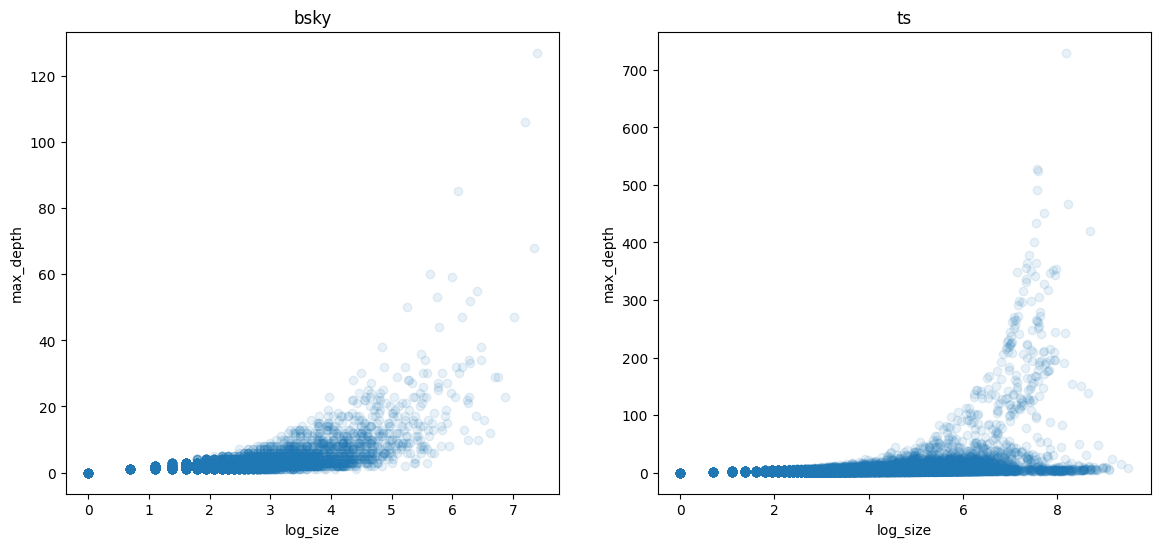

In [13]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(
    rp_bsky_df["log_size"], rp_bsky_df["max_depth"], label="bsky", alpha=0.1
)
axes[1].scatter(rp_ts_df["log_size"], rp_ts_df["max_depth"], label="ts", alpha=0.1)
axes[0].set_xlabel("log_size")
axes[0].set_ylabel("max_depth")
axes[1].set_xlabel("log_size")
axes[1].set_ylabel("max_depth")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()

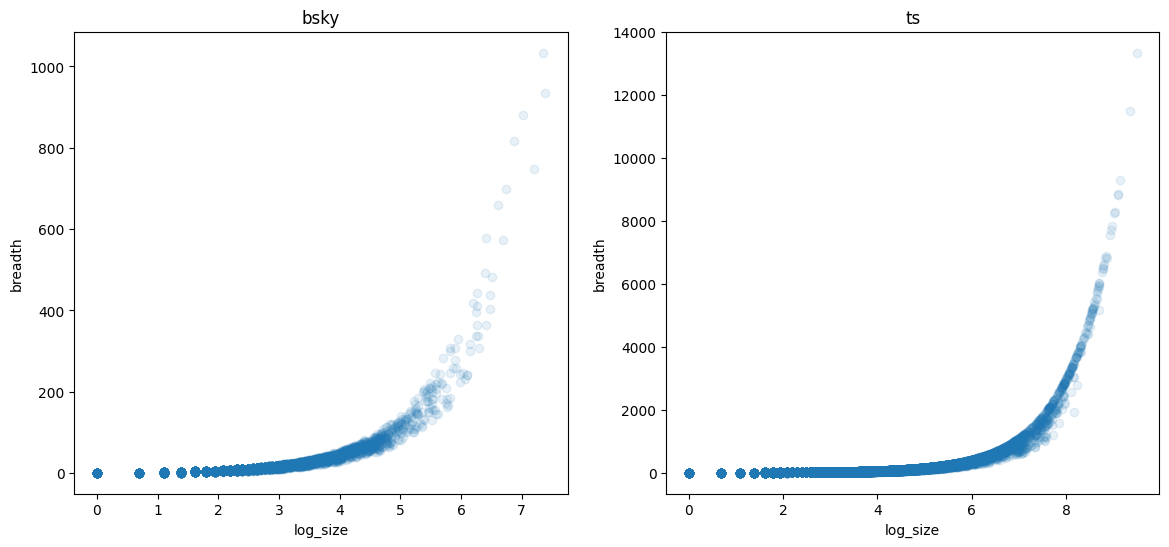

In [14]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(
    rp_bsky_df["log_size"], rp_bsky_df["breadth"], label="bsky", alpha=0.1
)
axes[1].scatter(rp_ts_df["log_size"], rp_ts_df["breadth"], label="ts", alpha=0.1)
axes[0].set_xlabel("log_size")
axes[0].set_ylabel("breadth")
axes[1].set_xlabel("log_size")
axes[1].set_ylabel("breadth")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()

In [15]:
rp_ts_df['breadth_size_ratio'] = rp_ts_df["breadth"]/rp_ts_df["size"]
rp_ts_df.sort_values(["size","breadth_size_ratio"], ascending=False).head(10)

index  max_depth     size  breadth  structural_virality  \
185835  112532453963389112        8.0  13423.0  13334.0             1.025160   
35258   112632701426261593       15.0  11590.0  11471.0             1.107696   
238394  112644111233618072       24.0   9391.0   9296.0             1.252303   
51773   112593884606525883        6.0   8905.0   8837.0             1.013677   
520876  112701895911797419        5.0   8886.0   8816.0             1.012593   
525819  112673301719650670        9.0   8342.0   8265.0             1.046662   
65749   112598565438227864        8.0   8323.0   8244.0             1.031671   
1508    112616824485224147        9.0   7910.0   7843.0             1.027428   
554320  112689069203113634        8.0   7774.0   7695.0             1.029851   
121274  112553579754674188        8.0   7614.0   7555.0             1.019353   

          reach             root_id  \
185835  13423.0  112532453963389112   
35258   11590.0  112632701426261593   
238394   9391.0  112644111233618072   
51773    8905.0  112593884606525883   
520876   8886.0  112701895911797419   
525819   8342.0  112673301719650670   
65749    8323.0  112598565438227864   
1508     7910.0  112616824485224147   
554320   7774.0  112689069203113634   
121274   7614.0  112553579754674188   

                                                     post  \
185835  PRESS CONFERENCE TOMORROW MORNING AT 11:00 A.M...   
35258   ANOTHER one of Crooked Joe Biden's Illegal Imm...   
238394  Nobody can ever trust Fox News, and I am one o...   
51773                           Biden Hates the Military!   
520876  This past Thursday night was a defeat not only...   
525819  DRUG TEST FOR CROOKED JOE BIDEN??? I WOULD, AL...   
65749   The Fake News Washington Post came up with the...   
1508                           “JOE BIDEN IS THE PROBLEM”   
554320  JOE BIDEN IS A THREAT TO DEMOCRACY, AND A THRE...   
121274  Biden Migrant Crime is out of control and is r...   

                                              topic_label platform  log_size  \
185835           Trump’s Rallies and Live Events Coverage       ts  9.504725   
35258   Biden’s Immigration Policies and Executive Orders       ts  9.357898   
238394         Trump’s Tax Promises and Election Campaign       ts  9.147507   
51773                   U.S. Policy on Ukraine and Russia       ts  9.094368   
520876               Biden vs. Trump Presidential Debates       ts  9.092232   
525819               Biden vs. Trump Presidential Debates       ts  9.029058   
65749          Trump’s Tax Promises and Election Campaign       ts  9.026778   
1508                 Biden vs. Trump Presidential Debates       ts  8.975883   
554320                  U.S. Policy on Ukraine and Russia       ts  8.958540   
121274  Biden’s Immigration Policies and Executive Orders       ts  8.937744   

        breadth_size_ratio  
185835            0.993370  
35258             0.989733  
238394            0.989884  
51773             0.992364  
520876            0.992122  
525819            0.990770  
65749             0.990508  
1508              0.991530  
554320            0.989838  
121274            0.992251

In [3]:
from pprint import pprint
for post in ts_raw:
    if post["_id"] == "112532453963389112":
        pprint(post)
        break

{'_id': '112532453963389112',
 'account': {'accepting_messages': False,
             'acct': 'realDonaldTrump',
             'avatar': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/107/780/257/626/128/497/original/454286ac07a6f6e6.jpeg',
             'avatar_static': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/avatars/107/780/257/626/128/497/original/454286ac07a6f6e6.jpeg',
             'bot': False,
             'chats_onboarded': True,
             'created_at': '2022-02-11T16:16:57.705Z',
             'discoverable': None,
             'display_name': 'Donald J. Trump',
             'emojis': [],
             'feeds_onboarded': True,
             'fields': [],
             'followers_count': 7069207,
             'following_count': 66,
             'group': False,
             'header': 'https://static-assets-1.truthsocial.com/tmtg:prime-ts-assets/accounts/headers/107/780/257/626/128/497/original/ba3b910ba387bf4e.jpeg',
   

In [21]:
for ids in rp_ts_df.sort_values(["size","breadth_size_ratio"], ascending=False).head(20)["index"]:
    for post in ts_raw:
        if post["_id"] == str(ids):
            print(ids, post['account']['username'])
            break

112532453963389112 realDonaldTrump
112632701426261593 realDonaldTrump
112644111233618072 realDonaldTrump
112593884606525883 realDonaldTrump
112701895911797419 realDonaldTrump
112673301719650670 realDonaldTrump
112598565438227864 realDonaldTrump
112616824485224147 realDonaldTrump
112689069203113634 realDonaldTrump
112553579754674188 realDonaldTrump
112533032884862739 DevinNunes
112581578465882555 realDonaldTrump
112606332618773080 realDonaldTrump
112701886045458710 realDonaldTrump
112692120272329840 realDonaldTrump
112686156652032011 realDonaldTrump
112582683776183914 realDonaldTrump
112692075080303729 realDonaldTrump
112606304076668141 realDonaldTrump
112679114827288819 realDonaldTrump


In [19]:
ids

112553579754674188